In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
df = pd.read_csv('reported_hospital_capacity_admissions_facility_level_weekly_average_timeseries_20210103_geocoded.csv', index_col=0)
df

,hospital_pk,collection_week,state,ccn,hospital_name,address,city,zip,hospital_subtype,fips_code,...,previous_day_admission_adult_covid_suspected_50-59_7_day_sum,previous_day_admission_adult_covid_suspected_60-69_7_day_sum,previous_day_admission_adult_covid_suspected_70-79_7_day_sum,previous_day_admission_adult_covid_suspected_80+_7_day_sum,previous_day_admission_adult_covid_suspected_unknown_7_day_sum,previous_day_admission_pediatric_covid_suspected_7_day_sum,previous_day_total_ED_visits_7_day_sum,previous_day_admission_influenza_confirmed_7_day_sum,lat,lng
0,df2363988746840134806aa7b2accf9c89259601776986...,2020-12-25,PR,NaN,Hospital San Antonio,#18 Norte Calle Ramón Emeterio Betances,Mayagüez,680.0,Short Term,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,166.0,0.0,18.203115,-67.141196
1,3b081d5ef1c552538e4af4aa593a857bb922a4f364a412...,2020-12-25,LA,NaN,Surgery Center of Zachary,4845 Main St,Zachary,70791.0,Short Term,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.648624,-91.152534
2,452193,2020-12-25,TX,452193,El Paso LTAC Hospital,1221 N Cotton St,El Paso,79902.0,Long Term,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.783761,-106.474257
3,aab2bb3ab769da90baf57242c96ec481afb5ec6a233784...,2020-12-25,LA,NaN,Crescent City Surgical Centre,3017 Galleria,Metairie,70118.0,Short Term,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.993260,-90.153020
4,9922a3f069ff4686fe467885206fb1172f609233cfe517...,2020-12-25,PR,NaN,Centro Medico Correccional de Bayamon,Expreso Río Hondo,Bayamón,960.0,Short Term,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.417689,-66.148070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106954,400130,2020-07-31,PR,400130,HOSPITAL METROPOLITANO DE LA MONTANA,NaN,Utuado,641.0,Short Term,72141.0,...,0.0,0.0,0.0,0.0,0.0,0.0,35.0,NaN,18.267567,-66.701342
106955,400115,2020-07-31,PR,400115,CENTRO MEDICO WILMA N VAZQUEZ,Carretera #2 Km,Vega Baja,693.0,Short Term,72145.0,...,9.0,12.0,9.0,10.0,0.0,4.0,170.0,NaN,18.445622,-66.398985
106956,400110,2020-07-31,PR,400110,HOSPITAL METROPOLITANO DR TITO MATTEI,NaN,Yauco,698.0,Short Term,72153.0,...,0.0,4.0,0.0,0.0,0.0,0.0,274.0,NaN,18.031410,-66.857723
106957,480002,2020-07-31,VI,480002,GOV JUAN F LUIS HOSPITAL & MEDICAL CTR,4007 Estate Diamond Ruby,Christiansted,820.0,Short Term,78010.0,...,0.0,0.0,0.0,-999999.0,0.0,0.0,193.0,NaN,17.733683,-64.751426


In [3]:
print(df.columns)

Index(['hospital_pk', 'collection_week', 'state', 'ccn', 'hospital_name',
       'address', 'city', 'zip', 'hospital_subtype', 'fips_code',
       'is_metro_micro', 'total_beds_7_day_avg',
       'all_adult_hospital_beds_7_day_avg',
       'all_adult_hospital_inpatient_beds_7_day_avg',
       'inpatient_beds_used_7_day_avg',
       'all_adult_hospital_inpatient_bed_occupied_7_day_avg',
       'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg',
       'total_adult_patients_hospitalized_confirmed_covid_7_day_avg',
       'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg',
       'total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg',
       'inpatient_beds_7_day_avg', 'total_icu_beds_7_day_avg',
       'total_staffed_adult_icu_beds_7_day_avg', 'icu_beds_used_7_day_avg',
       'staffed_adult_icu_bed_occupancy_7_day_avg',
       'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg',
       'staffed_icu_adult_p

In [4]:
df['zip'] = df['zip'].apply(lambda x: int(x) if x == x else "")

In [5]:
df = df.sort_values(['collection_week']).reset_index(drop=True)

# Data Exploration

### Assumptions

Total beds vs. inpatient beds - Inpatient beds are defined as beds that are regularly maintained and staffed [[source]](https://deputyprimeminister.gov.mt/en/dhir/documents/definitions_and_classifications.pdf)

The value `-999999` indicates redacted data due to privacy concerns. From HealthcareGov:
> When there are fewer than 4 patients in a data field the cell is redacted and replaced with -999999. This value was chosen to ensure that users would not make the mistake of quickly “averaging” a column to come to a conclusion that does not account for the fact that many of the cells contain too few patients to release (for privacy concerns). To conduct analysis on this data, one must decide how to handle the -999999 fields.

tl;dr: If calculated metric falls out of bounds, recalculate using related values. Redacted values will be interpreted as 1 only in a last-case scenario, as we know there is at least 1 patient given the conditions of redaction.

### Goal

Visualize capacity week by week. Due to low occurance of pediatric cases, only adult patient metrics are calculated.
 
What data do we need?
- ID: `hospital_name`
- Location: `hospital_name`, `address`, `city`, `zip`, `lat`, `lng`

Metric calculations, ideal:

- Percentage of Bed Occupancy (COVID and non-COVID) (Of all beds, how many are occupied?):
`all_adult_hospital_inpatient_bed_occupied_7_day_avg / all_adult_hospital_inpatient_beds_7_day_avg `
- Percentage of Patients with COVID (Of all beds, how many are occupied by patients with COVID?):
`total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg / all_adult_hospital_inpatient_bed_occupied_7_day_avg`

- Percentage of ICU Occupancy (COVID and non-COVID) (Of all ICU beds, how many are occupied?): 
`staffed_adult_icu_bed_occupancy_7_day_avg / total_staffed_adult_icu_beds_7_day_avg`
- Percentage of ICU Occupancy (COVID and non-COVID) (Of all ICU beds, how many are occupied by patients with COVID?):
`staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg / total_staffed_adult_icu_beds_7_day_avg`

List of all values available for calculating/estimating metrics:

`'all_adult_hospital_inpatient_beds_7_day_avg'`
`'all_adult_hospital_inpatient_bed_occupied_7_day_avg'`
`'inpatient_beds_used_7_day_avg'`
`'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'`
`'total_adult_patients_hospitalized_confirmed_covid_7_day_avg'`
`'total_beds_7_day_avg'`

`'total_staffed_adult_icu_beds_7_day_avg'`
`'staffed_adult_icu_bed_occupancy_7_day_avg'`
`'icu_beds_used_7_day_avg'`
`'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg'`
`'staffed_icu_adult_patients_confirmed_covid_7_day_avg'`
`'total_icu_beds_7_day_avg'`

In [6]:
weeks_list = df['collection_week'].unique()
print(weeks_list)
print(f'{len(weeks_list)} weeks of data')

['2020-07-31' '2020-08-07' '2020-08-14' '2020-08-21' '2020-08-28'
 '2020-09-04' '2020-09-11' '2020-09-18' '2020-09-25' '2020-10-02'
 '2020-10-09' '2020-10-16' '2020-10-23' '2020-10-30' '2020-11-06'
 '2020-11-13' '2020-11-20' '2020-11-27' '2020-12-04' '2020-12-11'
 '2020-12-18' '2020-12-25']
22 weeks of data


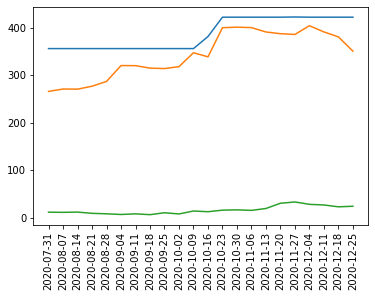

In [7]:
df_sample = df[df['hospital_name'] == 'OHSU HOSPITAL AND CLINICS']
plt.plot(df_sample['collection_week'], df_sample['all_adult_hospital_inpatient_beds_7_day_avg'])
plt.plot(df_sample['collection_week'], df_sample['all_adult_hospital_inpatient_bed_occupied_7_day_avg'])
plt.plot(df_sample['collection_week'], df_sample['total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'])
plt.xticks(rotation=90)
plt.show()

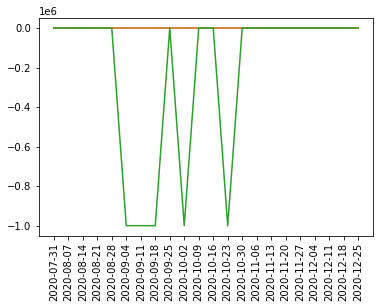

In [8]:
plt.plot(df_sample['collection_week'], df_sample['total_staffed_adult_icu_beds_7_day_avg'])
plt.plot(df_sample['collection_week'], df_sample['staffed_adult_icu_bed_occupancy_7_day_avg'])
plt.plot(df_sample['collection_week'], df_sample['staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg'])
plt.xticks(rotation=90)
plt.show()

Data looks interesting, but redacted values need to go. Errors exist in the entry of data, they must be corrected as well.

In [9]:
df_explore = df.copy(deep=True)

No redacted values here

 **NOTE TO SELF: REPLACING WITH `None` DOES NOT WORK. PANDAS WILL INFER DATA FROM ROW ABOVE**

In [10]:
avg_cols = ['all_adult_hospital_inpatient_beds_7_day_avg', 
            'all_adult_hospital_inpatient_bed_occupied_7_day_avg', 
            'inpatient_beds_used_7_day_avg',
            'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg',
            'total_adult_patients_hospitalized_confirmed_covid_7_day_avg',
            'total_beds_7_day_avg',
           
            'total_staffed_adult_icu_beds_7_day_avg', 
            'staffed_adult_icu_bed_occupancy_7_day_avg', 
            'icu_beds_used_7_day_avg',
            'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg',
            'staffed_icu_adult_patients_confirmed_covid_7_day_avg',
            'total_icu_beds_7_day_avg']

sum_cols = ['all_adult_hospital_inpatient_beds_7_day_sum', 
            'all_adult_hospital_inpatient_bed_occupied_7_day_sum', 
            'inpatient_beds_used_7_day_sum',
            'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum',
            'total_adult_patients_hospitalized_confirmed_covid_7_day_sum',
            'total_beds_7_day_sum', 
            
            'total_staffed_adult_icu_beds_7_day_sum', 
            'staffed_adult_icu_bed_occupancy_7_day_sum', 
            'icu_beds_used_7_day_sum',
            'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum',
            'staffed_icu_adult_patients_confirmed_covid_7_day_sum',
            'total_icu_beds_7_day_sum']

cov_cols = ['all_adult_hospital_inpatient_beds_7_day_coverage', 
            'all_adult_hospital_inpatient_bed_occupied_7_day_coverage', 
            'inpatient_beds_used_7_day_coverage',
            'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage',
            'total_adult_patients_hospitalized_confirmed_covid_7_day_coverage',
            'total_beds_7_day_coverage',
            
            'total_staffed_adult_icu_beds_7_day_coverage', 
            'staffed_adult_icu_bed_occupancy_7_day_coverage', 
            'icu_beds_used_7_day_coverage',
            'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage',
            'staffed_icu_adult_patients_confirmed_covid_7_day_coverage',
            'total_icu_beds_7_day_coverage']

In [11]:
for col in avg_cols:
    df_explore[col].replace(-999999, np.nan, inplace=True)
    #df_explore[col].mask(lambda x: x==-999999, None, inplace=True)
    print(f'Min: {df_explore[col].min()} | Max: {df_explore[col].max()}')

Min: 0.0 | Max: 2875.4
Min: -6.3 | Max: 64459.1
Min: -17.8 | Max: 2442.4
Min: 0.0 | Max: 929.0
Min: 0.0 | Max: 771.1
Min: 0.0 | Max: 5015.4
Min: 0.0 | Max: 557.7
Min: -3.2 | Max: 5864.4
Min: -3.5 | Max: 412.7
Min: 0.0 | Max: 201.1
Min: 0.0 | Max: 140.4
Min: 0.0 | Max: 849.9


In [12]:
for col in sum_cols:
    df_explore[col].replace(-999999, np.nan, inplace=True)
    print(f'Min: {df_explore[col].min()} | Max: {df_explore[col].max()}')

Min: 0.0 | Max: 20128.0
Min: -44.0 | Max: 451214.0
Min: -107.0 | Max: 17097.0
Min: 0.0 | Max: 6503.0
Min: 0.0 | Max: 5398.0
Min: 0.0 | Max: 35108.0
Min: 0.0 | Max: 3904.0
Min: -19.0 | Max: 41051.0
Min: -21.0 | Max: 2889.0
Min: 0.0 | Max: 1408.0
Min: 0.0 | Max: 983.0
Min: 0.0 | Max: 5949.0


In [13]:
for col in cov_cols:
    df_explore[col].replace(-999999, np.nan, inplace=True)
    print(f'Min: {df_explore[col].min()} | Max: {df_explore[col].max()}')

Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7
Min: 0 | Max: 7


Why are there negative numbers???

In [14]:
for i, col in enumerate(avg_cols):
    df_neg = df_explore.loc[df_explore[col] < 0][[avg_cols[i], sum_cols[i], cov_cols[i]]]
    if not df_neg.empty:
        display(df_neg)

,all_adult_hospital_inpatient_bed_occupied_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_coverage
9014,-3.0,-12.0,4
13704,-4.6,-23.0,5
18500,-4.4,-22.0,5
23323,-4.6,-32.0,7
47671,-6.3,-44.0,7
52537,-1.6,-11.0,7


,inpatient_beds_used_7_day_avg,inpatient_beds_used_7_day_sum,inpatient_beds_used_7_day_coverage
9014,-2.4,-12.0,5
13704,-4.6,-23.0,5
18500,-4.4,-22.0,5
23323,-4.6,-32.0,7
28699,-17.8,-107.0,6
47671,-6.3,-44.0,7
52537,-1.6,-11.0,7


,staffed_adult_icu_bed_occupancy_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_coverage
9014,-1.0,-4.0,4
13704,-1.0,-5.0,5
18500,-1.0,-5.0,5
23323,-1.0,-7.0,7
28699,-3.2,-19.0,6
47671,-1.0,-7.0,7
52537,-0.1,-1.0,7


,icu_beds_used_7_day_avg,icu_beds_used_7_day_sum,icu_beds_used_7_day_coverage
9014,-0.8,-4.0,5
13704,-1.0,-5.0,5
18500,-1.0,-5.0,5
23323,-1.0,-7.0,7
28699,-3.5,-21.0,6
47671,-1.0,-7.0,7
52537,-0.1,-1.0,7


Seems like misentered data. For all negative values that are not redacted, we can take the absolute value of all columns

In [15]:
for col in [avg_cols + sum_cols + cov_cols]:
    df_explore[col] = df_explore[col].abs()

In [16]:
#print min
for avg_col, sum_col, cov_col in zip(avg_cols, sum_cols, cov_cols):
    print(f'Avg - Min: {df_explore[avg_col].min()} | Max: {df_explore[avg_col].max()}')
    print(f'Sum - Min: {df_explore[sum_col].min()} | Max: {df_explore[sum_col].max()}')
    print(f'Cov - Min: {df_explore[cov_col].min()} | Max: {df_explore[cov_col].max()}')

Avg - Min: 0.0 | Max: 2875.4
Sum - Min: 0.0 | Max: 20128.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 64459.1
Sum - Min: 0.0 | Max: 451214.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 2442.4
Sum - Min: 0.0 | Max: 17097.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 929.0
Sum - Min: 0.0 | Max: 6503.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 771.1
Sum - Min: 0.0 | Max: 5398.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 5015.4
Sum - Min: 0.0 | Max: 35108.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 557.7
Sum - Min: 0.0 | Max: 3904.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 5864.4
Sum - Min: 0.0 | Max: 41051.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 412.7
Sum - Min: 0.0 | Max: 2889.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 201.1
Sum - Min: 0.0 | Max: 1408.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 140.4
Sum - Min: 0.0 | Max: 983.0
Cov - Min: 0.0 | Max: 7.0
Avg - Min: 0.0 | Max: 849.9
Sum - Min: 0.0 | Max: 5949.0
Cov - Min: 0.0 | Ma

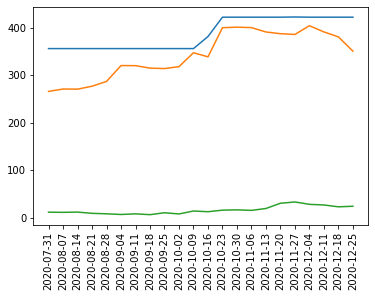

In [17]:
df_sample = df_explore[df_explore['hospital_name'] == 'OHSU HOSPITAL AND CLINICS']
plt.plot(df_sample['collection_week'], df_sample['all_adult_hospital_inpatient_beds_7_day_avg'])
plt.plot(df_sample['collection_week'], df_sample['all_adult_hospital_inpatient_bed_occupied_7_day_avg'])
plt.plot(df_sample['collection_week'], df_sample['total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'])
plt.xticks(rotation=90)
plt.show()

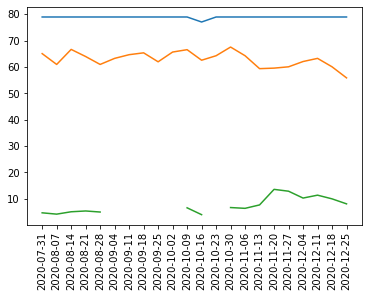

In [18]:
plt.plot(df_sample['collection_week'], df_sample['total_staffed_adult_icu_beds_7_day_avg'])
plt.plot(df_sample['collection_week'], df_sample['staffed_adult_icu_bed_occupancy_7_day_avg'])
plt.plot(df_sample['collection_week'], df_sample['staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg'])
plt.xticks(rotation=90)
plt.show()

In [19]:
df_explore.loc[(df_explore['total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'] != -999999) & 
               (df_explore['total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'] <
               df_explore['total_adult_patients_hospitalized_confirmed_covid_7_day_avg'])][['hospital_name', 'collection_week', 
                'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg',
                'total_adult_patients_hospitalized_confirmed_covid_7_day_avg']]

,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_avg
770,RUSH FOUNDATION HOSPITAL,2020-07-31,10.3,16.3
1738,HAVASU REGIONAL MEDICAL CENTER,2020-07-31,16.0,17.4
2436,MESQUITE SPECIALTY HOSPITAL,2020-07-31,5.4,6.2
3164,BAYAMON MEDICAL CENTER,2020-07-31,7.0,9.1
3165,HOSPITAL UNIVERSITARIO DR RUIZ ARNAU,2020-07-31,5.7,5.9
...,...,...,...,...
103079,BATON ROUGE GENERAL MEDICAL CENTER,2020-12-25,46.9,47.0
103091,GLENWOOD REGIONAL MEDICAL CENTER,2020-12-25,38.1,771.1
103095,RIVERSIDE HOSPITAL OF LOUISIANA,2020-12-25,0.0,9.4
106198,SAINT ROSE DOMINICAN HOSPITALS - SAN MARTIN CA...,2020-12-25,9.7,60.0


Since `confirmed_and_suspected_covid` should be a subset of `confirmed_covid`, the former should always be larger than the latter. **I assume the data was simply misentered, and will use whichever value is larger but not both** 

**Reset**

In [20]:
df_explore = df.copy(deep=True)

## Estimation Logic Tree - Inpatient

Four metrics are calculated, always by `occupied_avg / avg`. I'll tackle them two at a time

For total inpatient occupancy metric:

`occupied_avg` calculation methods:
1. `'all_adult_hospital_inpatient_bed_occupied_7_day_avg'`
2. `'all_adult_hospital_inpatient_bed_occupied_7_day_sum' / 'all_adult_hospital_inpatient_bed_occupied_7_day_coverage'`
3. `'inpatient_beds_used_7_day_avg'` **<-- ESTIMATE | IF USING THEN USE ESTIMATE** `avg` **FOR CALCULATION**
4. `'inpatient_beds_used_7_day_sum' / 'inpatient_beds_used_7_day_coverage'`

`avg` calculation methods:
1. `'all_adult_hospital_inpatient_beds_7_day_avg'`
2. `'all_adult_hospital_inpatient_beds_7_day_sum' / 'all_adult_hospital_inpatient_beds_7_day_coverage'`
3. `'all_adult_hospital_beds_7_day_avg'`
4. `'all_adult_hospital_beds_7_day_sum' / 'all_adult_hospital_beds_7_day_coverage'`
5. `'total_beds_7_day_avg'` **<-- ESTIMATE | IF USING THEN USE ESTIMATE** `occupied_avg` **FOR CALCULATION**
6. `'total_beds_7_day_sum' / 'total_beds_7_day_coverage'` **<-- ESTIMATE | IF USING THEN USE ESTIMATE** `occupied_avg` **FOR CALCULATION**

For COVID inpatient occupancy metric:
    
`occupied_avg` calculation methods:
1. `'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'` **OR** `'total_adult_patients_hospitalized_confirmed_covid_7_day_avg'`, whichever is larger
2. `'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum / 'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg'` **OR**
`'total_adult_patients_hospitalized_confirmed_covid_7_day_sum' / 'total_adult_patients_hospitalized_confirmed_covid_7_day_coverage'`, whichever is larger

`avg` calculation methods:
1. `'all_adult_hospital_inpatient_beds_7_day_avg'`
2. `'all_adult_hospital_inpatient_beds_7_day_sum' / 'all_adult_hospital_inpatient_beds_7_day_coverage'`
3. `'all_adult_hospital_beds_7_day_avg'`
4. `'all_adult_hospital_beds_7_day_sum' / 'all_adult_hospital_beds_7_day_coverage'`
5. `'total_beds_7_day_avg'` **<-- ESTIMATE**
6. `'total_beds_7_day_sum' / 'total_beds_7_day_coverage'` **<-- ESTIMATE**

In [21]:
avg_cols = ['all_adult_hospital_inpatient_beds_7_day_avg', 
            'all_adult_hospital_inpatient_bed_occupied_7_day_avg', 
            'inpatient_beds_used_7_day_avg',
            'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg',
            'total_adult_patients_hospitalized_confirmed_covid_7_day_avg',
            'total_beds_7_day_avg']

sum_cols = ['all_adult_hospital_inpatient_beds_7_day_sum', 
            'all_adult_hospital_inpatient_bed_occupied_7_day_sum', 
            'inpatient_beds_used_7_day_sum',
            'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum',
            'total_adult_patients_hospitalized_confirmed_covid_7_day_sum',
            'total_beds_7_day_sum']

cov_cols = ['all_adult_hospital_inpatient_beds_7_day_coverage', 
            'all_adult_hospital_inpatient_bed_occupied_7_day_coverage', 
            'inpatient_beds_used_7_day_coverage',
            'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage',
            'total_adult_patients_hospitalized_confirmed_covid_7_day_coverage',
            'total_beds_7_day_coverage']

### Primary calculation method

In [22]:
for avg_col, sum_col in zip(avg_cols, sum_cols):
    print(f'{avg_col} vs. {sum_col}')
    display(df_explore.loc[lambda row: (row[avg_col] == 0) & (row[sum_col] != 0)]
            [['hospital_name', 'collection_week', avg_col, sum_col]]
           )
    display(df_explore.loc[lambda row: np.isnan(row[avg_col]) & ~np.isnan(row[sum_col])]
            [['hospital_name', 'collection_week', avg_col, sum_col]]
           )
    display(
        df_explore.loc[lambda row: (row[avg_col] == -999999) & (row[sum_col] != -999999)]
            [['hospital_name', 'collection_week', avg_col, sum_col]]
    )

all_adult_hospital_inpatient_beds_7_day_avg vs. all_adult_hospital_inpatient_beds_7_day_sum


,hospital_name,collection_week,all_adult_hospital_inpatient_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_sum


,hospital_name,collection_week,all_adult_hospital_inpatient_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_sum


,hospital_name,collection_week,all_adult_hospital_inpatient_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_sum
29,COMANCHE COUNTY HOSPITAL,2020-07-31,-999999.0,4.0
40,HILLSBORO COMMUNITY HOSPITAL,2020-07-31,-999999.0,19.0
42,MEADE DISTRICT HOSPITAL,2020-07-31,-999999.0,12.0
52,NORTON COUNTY HOSPITAL,2020-07-31,-999999.0,25.0
73,OSBORNE COUNTY MEMORIAL HOSPITAL,2020-07-31,-999999.0,17.0
...,...,...,...,...
106316,GENOA COMMUNITY HOSPITAL,2020-12-25,-999999.0,21.0
106359,MEMORIAL HOSPITAL OF TEXAS COUNTY AUTHORITY,2020-12-25,-999999.0,10.0
106451,"MERCY HOSPITAL WATONGA, INC",2020-12-25,-999999.0,22.0
106661,SOUTH CENTRAL HEALTH,2020-12-25,-999999.0,27.0


all_adult_hospital_inpatient_bed_occupied_7_day_avg vs. all_adult_hospital_inpatient_bed_occupied_7_day_sum


,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_sum


,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_sum


,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,-999999.0,4.0
21,MERCY HOSPITAL COLUMBUS,2020-07-31,-999999.0,7.0
22,MERCY SPECIALTY HOSPITAL SOUTHEAST KANSAS,2020-07-31,-999999.0,25.0
29,COMANCHE COUNTY HOSPITAL,2020-07-31,-999999.0,5.0
34,SATANTA DISTRICT HOSPITAL,2020-07-31,-999999.0,5.0
...,...,...,...,...
106876,KINGS DAUGHTERS MEDICAL CENTER OHIO,2020-12-25,-999999.0,10.0
106892,COMMUNITY MEMORIAL HOSPITAL,2020-12-25,-999999.0,24.0
106897,DILEY RIDGE MEDICAL CENTER,2020-12-25,-999999.0,4.0
106920,MOUNT CARMEL NEW ALBANY SURGICAL HOSPITAL,2020-12-25,-999999.0,21.0


inpatient_beds_used_7_day_avg vs. inpatient_beds_used_7_day_sum


,hospital_name,collection_week,inpatient_beds_used_7_day_avg,inpatient_beds_used_7_day_sum


,hospital_name,collection_week,inpatient_beds_used_7_day_avg,inpatient_beds_used_7_day_sum


,hospital_name,collection_week,inpatient_beds_used_7_day_avg,inpatient_beds_used_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,-999999.0,4.0
15,GRAHAM COUNTY HOSPITAL,2020-07-31,-999999.0,8.0
21,MERCY HOSPITAL COLUMBUS,2020-07-31,-999999.0,7.0
22,MERCY SPECIALTY HOSPITAL SOUTHEAST KANSAS,2020-07-31,-999999.0,25.0
23,CHEYENNE COUNTY HOSPITAL,2020-07-31,-999999.0,12.0
...,...,...,...,...
106876,KINGS DAUGHTERS MEDICAL CENTER OHIO,2020-12-25,-999999.0,10.0
106892,COMMUNITY MEMORIAL HOSPITAL,2020-12-25,-999999.0,24.0
106897,DILEY RIDGE MEDICAL CENTER,2020-12-25,-999999.0,4.0
106920,MOUNT CARMEL NEW ALBANY SURGICAL HOSPITAL,2020-12-25,-999999.0,21.0


total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg vs. total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum
0,"ROY LESTER SCHNEIDER HOSPITAL,THE",2020-07-31,-999999.0,21.0
2,HAYS MEDICAL CENTER,2020-07-31,-999999.0,15.0
4,ST CATHERINE HOSPITAL,2020-07-31,-999999.0,10.0
5,ADVENTHEALTH OTTAWA,2020-07-31,-999999.0,22.0
6,GEARY COMMUNITY HOSPITAL,2020-07-31,-999999.0,10.0
...,...,...,...,...
106928,HARDIN MEMORIAL HOSPITAL,2020-12-25,-999999.0,7.0
106930,"HENRY COUNTY HOSPITAL, INC",2020-12-25,-999999.0,4.0
106932,GREENFIELD AREA MEDICAL CENTER,2020-12-25,-999999.0,24.0
106947,"SELECT SPECIALTY HOSPITAL-COLUMBUS, INC",2020-12-25,-999999.0,15.0


total_adult_patients_hospitalized_confirmed_covid_7_day_avg vs. total_adult_patients_hospitalized_confirmed_covid_7_day_sum


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_sum


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_sum


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_covid_7_day_avg,total_adult_patients_hospitalized_confirmed_covid_7_day_sum
0,"ROY LESTER SCHNEIDER HOSPITAL,THE",2020-07-31,-999999.0,21.0
2,HAYS MEDICAL CENTER,2020-07-31,-999999.0,15.0
4,ST CATHERINE HOSPITAL,2020-07-31,-999999.0,7.0
5,ADVENTHEALTH OTTAWA,2020-07-31,-999999.0,5.0
6,GEARY COMMUNITY HOSPITAL,2020-07-31,-999999.0,10.0
...,...,...,...,...
106930,"HENRY COUNTY HOSPITAL, INC",2020-12-25,-999999.0,4.0
106932,GREENFIELD AREA MEDICAL CENTER,2020-12-25,-999999.0,24.0
106933,HOCKING VALLEY COMMUNITY HOSPITAL,2020-12-25,-999999.0,24.0
106947,"SELECT SPECIALTY HOSPITAL-COLUMBUS, INC",2020-12-25,-999999.0,15.0


total_beds_7_day_avg vs. total_beds_7_day_sum


,hospital_name,collection_week,total_beds_7_day_avg,total_beds_7_day_sum


,hospital_name,collection_week,total_beds_7_day_avg,total_beds_7_day_sum


,hospital_name,collection_week,total_beds_7_day_avg,total_beds_7_day_sum
1259,SURPRISE VALLEY COMMUNITY HOSPITAL,2020-07-31,-999999.0,12.0
1769,EUREKA SPRINGS HOSPITAL COMMISSION,2020-07-31,-999999.0,8.0
1852,NORTHRIDGE MEDICAL CENTER,2020-07-31,-999999.0,4.0
2613,ASPIRE HOSPITAL,2020-07-31,-999999.0,5.0
2634,HOUSTON METHODIST CONTINUING CARE HOSPITAL,2020-07-31,-999999.0,26.0
...,...,...,...,...
104701,ASPIRE HOSPITAL,2020-12-25,-999999.0,8.0
105561,TEXAS HEALTH SPECIALTY HOSPITAL FORT WORTH,2020-12-25,-999999.0,5.0
106043,SHRINERS HOSPITALS FOR CHILDREN,2020-12-25,-999999.0,11.0
106359,MEMORIAL HOSPITAL OF TEXAS COUNTY AUTHORITY,2020-12-25,-999999.0,10.0


If the `avg` is `nan` or `0`, then the `sum` is also `nan` or `0`.

However, there are conditions where `avg` is `-999999` but `sum` is not. In these cases, use `sum` and `coverage` to calculate `avg`

Therefore, if `avg` is `-999999`, use `sum/coverage`. If `avg` is `nan` or `0` we skip using `sum/coverage` and move to using an estimation method

In [23]:
for avg_col, sum_col in zip(avg_cols, sum_cols):
    print(f'{avg_col} vs. {sum_col}')
    display(
        df_explore.loc[lambda row: (row[sum_col] == 0) & (row[avg_col] != 0)]
            [['hospital_name', 'collection_week', sum_col, avg_col]]
    )
    display(
        df_explore.loc[lambda row: np.isnan(row[sum_col]) & ~np.isnan(row[avg_col])]
            [['hospital_name', 'collection_week', sum_col, avg_col]]
    )
    display(
        df_explore.loc[lambda row: (row[sum_col] == -999999) & (row[avg_col] != -999999)]
            [['hospital_name', 'collection_week', sum_col, avg_col]]
    )

all_adult_hospital_inpatient_beds_7_day_avg vs. all_adult_hospital_inpatient_beds_7_day_sum


,hospital_name,collection_week,all_adult_hospital_inpatient_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_avg


,hospital_name,collection_week,all_adult_hospital_inpatient_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_avg


,hospital_name,collection_week,all_adult_hospital_inpatient_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_avg


all_adult_hospital_inpatient_bed_occupied_7_day_avg vs. all_adult_hospital_inpatient_bed_occupied_7_day_sum


,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_avg


,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_avg


,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_avg


inpatient_beds_used_7_day_avg vs. inpatient_beds_used_7_day_sum


,hospital_name,collection_week,inpatient_beds_used_7_day_sum,inpatient_beds_used_7_day_avg


,hospital_name,collection_week,inpatient_beds_used_7_day_sum,inpatient_beds_used_7_day_avg


,hospital_name,collection_week,inpatient_beds_used_7_day_sum,inpatient_beds_used_7_day_avg


total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg vs. total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg


total_adult_patients_hospitalized_confirmed_covid_7_day_avg vs. total_adult_patients_hospitalized_confirmed_covid_7_day_sum


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_avg


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_avg


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_covid_7_day_sum,total_adult_patients_hospitalized_confirmed_covid_7_day_avg


total_beds_7_day_avg vs. total_beds_7_day_sum


,hospital_name,collection_week,total_beds_7_day_sum,total_beds_7_day_avg


,hospital_name,collection_week,total_beds_7_day_sum,total_beds_7_day_avg


,hospital_name,collection_week,total_beds_7_day_sum,total_beds_7_day_avg


If `sum` is `-999999`, `0`, or `nan`, then `avg` follows.

Therefore, there if we fail to get a number from `avg`, we do not need to come back to `avg`. There is no condition where `avg` will take precedence over a `sum/coverage` metric

### Sum/Coverage 

Main concern is if coverage is 0

In [24]:
for col in cov_cols:
    print(f'Min: {df_explore[col].min()} | Max: {df_explore[col].max()}') #check for -999999
    print(df_explore[col].isnull().any()) #check for NaN

Min: 0 | Max: 7
False
Min: 0 | Max: 7
False
Min: 0 | Max: 7
False
Min: 0 | Max: 7
False
Min: 0 | Max: 7
False
Min: 0 | Max: 7
False


This simplifies the coding - we only need to check for `coverage=0` condition

In [25]:
for sum_col, cov_col in zip(sum_cols, cov_cols):
    print(f'{sum_col} vs. {cov_col}')
    display(
        df_explore.loc[lambda row: (row[cov_col] == 0) & ~(np.isin(row[sum_col], [0, -999999]) | np.isnan(row[sum_col]))]
                      [['hospital_name', 'collection_week', cov_col, sum_col]]
    )

all_adult_hospital_inpatient_beds_7_day_sum vs. all_adult_hospital_inpatient_beds_7_day_coverage


,hospital_name,collection_week,all_adult_hospital_inpatient_beds_7_day_coverage,all_adult_hospital_inpatient_beds_7_day_sum


all_adult_hospital_inpatient_bed_occupied_7_day_sum vs. all_adult_hospital_inpatient_bed_occupied_7_day_coverage


,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_coverage,all_adult_hospital_inpatient_bed_occupied_7_day_sum


inpatient_beds_used_7_day_sum vs. inpatient_beds_used_7_day_coverage


,hospital_name,collection_week,inpatient_beds_used_7_day_coverage,inpatient_beds_used_7_day_sum


total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum vs. total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum


total_adult_patients_hospitalized_confirmed_covid_7_day_sum vs. total_adult_patients_hospitalized_confirmed_covid_7_day_coverage


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_covid_7_day_coverage,total_adult_patients_hospitalized_confirmed_covid_7_day_sum


total_beds_7_day_sum vs. total_beds_7_day_coverage


,hospital_name,collection_week,total_beds_7_day_coverage,total_beds_7_day_sum


If `coverage` is `0`, then the sum is `0`, `nan`, or `-999999`. 

In [26]:
for sum_col, cov_col in zip(sum_cols, cov_cols):
    print(f'{sum_col} vs. {cov_col}')
    display(
        df_explore.loc[lambda row: (row[cov_col] == 0)][sum_col].unique()
    )

all_adult_hospital_inpatient_beds_7_day_sum vs. all_adult_hospital_inpatient_beds_7_day_coverage


array([nan])

all_adult_hospital_inpatient_bed_occupied_7_day_sum vs. all_adult_hospital_inpatient_bed_occupied_7_day_coverage


array([nan])

inpatient_beds_used_7_day_sum vs. inpatient_beds_used_7_day_coverage


array([nan])

total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum vs. total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage


array([nan])

total_adult_patients_hospitalized_confirmed_covid_7_day_sum vs. total_adult_patients_hospitalized_confirmed_covid_7_day_coverage


array([nan])

total_beds_7_day_sum vs. total_beds_7_day_coverage


array([nan])

If `coverage` is `0`, then the sum is **always** `nan`.

Therefore, if the coverage is `0` then we just skip the `sum/coverage` and move on. If we reached the end of the logic tree, mark the value as `nan`

In [27]:
for sum_col, cov_col in zip(sum_cols, cov_cols):
    print(f'{sum_col} vs. {cov_col}')
    display(
        df_explore.loc[lambda row: (row[cov_col] != 0) & np.isin(row[sum_col],[0,-999999])]
        [['hospital_name', 'collection_week', cov_col, sum_col]]
    )

all_adult_hospital_inpatient_beds_7_day_sum vs. all_adult_hospital_inpatient_beds_7_day_coverage


,hospital_name,collection_week,all_adult_hospital_inpatient_beds_7_day_coverage,all_adult_hospital_inpatient_beds_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,2,0.0
26,CLAY COUNTY MEDICAL CENTER,2020-07-31,5,0.0
62,CHILDREN'S MERCY HOSPITAL KANSAS,2020-07-31,7,0.0
70,SAINT LUKE'S CUSHING HOSPITAL,2020-07-31,7,0.0
318,PINCKNEYVILLE COMMUNITY HOSPITAL,2020-07-31,5,0.0
...,...,...,...,...
106909,CLEVELAND CLINIC CHILDREN'S HOSPITAL FOR REHAB,2020-12-25,4,0.0
106917,RAINBOW BABIES AND CHILDRENS HOSPITAL,2020-12-25,7,0.0
106922,SHRINERS HOSPITALS FOR CHILDREN - CINCINNATI,2020-12-25,7,0.0
106926,CINCINNATI CHILDREN'S HOSPITAL MEDICAL CENTER,2020-12-25,7,0.0


all_adult_hospital_inpatient_bed_occupied_7_day_sum vs. all_adult_hospital_inpatient_bed_occupied_7_day_coverage


,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_coverage,all_adult_hospital_inpatient_bed_occupied_7_day_sum
33,GIRARD MEDICAL CENTER,2020-07-31,1,-999999.0
62,CHILDREN'S MERCY HOSPITAL KANSAS,2020-07-31,7,0.0
70,SAINT LUKE'S CUSHING HOSPITAL,2020-07-31,7,0.0
85,MERCYONE PRIMGHAR MEDICAL CENTER,2020-07-31,7,-999999.0
203,ASSUMPTION COMMUNITY HOSPITAL,2020-07-31,5,0.0
...,...,...,...,...
106909,CLEVELAND CLINIC CHILDREN'S HOSPITAL FOR REHAB,2020-12-25,4,0.0
106917,RAINBOW BABIES AND CHILDRENS HOSPITAL,2020-12-25,7,0.0
106922,SHRINERS HOSPITALS FOR CHILDREN - CINCINNATI,2020-12-25,7,0.0
106926,CINCINNATI CHILDREN'S HOSPITAL MEDICAL CENTER,2020-12-25,7,0.0


inpatient_beds_used_7_day_sum vs. inpatient_beds_used_7_day_coverage


,hospital_name,collection_week,inpatient_beds_used_7_day_coverage,inpatient_beds_used_7_day_sum
18,DECATUR COUNTY HOSPITAL,2020-07-31,7,-999999.0
33,GIRARD MEDICAL CENTER,2020-07-31,1,-999999.0
70,SAINT LUKE'S CUSHING HOSPITAL,2020-07-31,7,0.0
85,MERCYONE PRIMGHAR MEDICAL CENTER,2020-07-31,3,-999999.0
203,ASSUMPTION COMMUNITY HOSPITAL,2020-07-31,5,0.0
...,...,...,...,...
106534,BUCKTAIL MEDICAL CENTER,2020-12-25,7,0.0
106670,NELSON COUNTY HEALTH SYSTEM,2020-12-25,7,-999999.0
106701,EAST OHIO REGIONAL HOSPITAL,2020-12-25,7,0.0
106787,HIGHLANDS CASHIERS HOSPITAL,2020-12-25,7,0.0


total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum vs. total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_coverage,total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,2,0.0
8,GOVE COUNTY MEDICAL CENTER,2020-07-31,5,0.0
9,BOB WILSON MEMORIAL GRANT COUNTY HOSPITAL,2020-07-31,7,-999999.0
10,GREELEY COUNTY HEALTH SERVICES,2020-07-31,7,0.0
12,HAMILTON COUNTY HOSPITAL,2020-07-31,2,-999999.0
...,...,...,...,...
106935,MERCY HEALTH - WILLARD HOSPITAL,2020-12-25,7,-999999.0
106941,NATIONWIDE CHILDREN'S HOSPITAL,2020-12-25,7,0.0
106943,JAMES CANCER HOSPITAL & SOLOVE RESEARCH INSTITUTE,2020-12-25,7,0.0
106952,GREENE MEMORIAL HOSPITAL,2020-12-25,7,0.0


total_adult_patients_hospitalized_confirmed_covid_7_day_sum vs. total_adult_patients_hospitalized_confirmed_covid_7_day_coverage


,hospital_name,collection_week,total_adult_patients_hospitalized_confirmed_covid_7_day_coverage,total_adult_patients_hospitalized_confirmed_covid_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,2,0.0
8,GOVE COUNTY MEDICAL CENTER,2020-07-31,5,0.0
9,BOB WILSON MEMORIAL GRANT COUNTY HOSPITAL,2020-07-31,7,0.0
12,HAMILTON COUNTY HOSPITAL,2020-07-31,2,-999999.0
13,PATTERSON HEALTH CENTER,2020-07-31,1,-999999.0
...,...,...,...,...
106935,MERCY HEALTH - WILLARD HOSPITAL,2020-12-25,7,-999999.0
106941,NATIONWIDE CHILDREN'S HOSPITAL,2020-12-25,7,0.0
106943,JAMES CANCER HOSPITAL & SOLOVE RESEARCH INSTITUTE,2020-12-25,7,0.0
106952,GREENE MEMORIAL HOSPITAL,2020-12-25,7,0.0


total_beds_7_day_sum vs. total_beds_7_day_coverage


,hospital_name,collection_week,total_beds_7_day_coverage,total_beds_7_day_sum
1227,GLENDORA OAKS BEHAVIORAL HEALTH HOSPITAL,2020-07-31,6,0.0
1246,GEORGE L MEE MEMORIAL HOSPITAL,2020-07-31,6,0.0
1406,SONOMA SPECIALTY HOSPITAL,2020-07-31,7,0.0
1599,Surgery Center of Zachary,2020-07-31,5,0.0
1603,HonorHealth Sonoran Emergency Center,2020-07-31,6,0.0
...,...,...,...,...
105946,HEALTHALLIANCE HOSPITAL MARY'S AVENUE CAMPUS,2020-12-25,7,0.0
105978,MONROE COMMUNITY HOSPITAL,2020-12-25,1,0.0
106459,INTEGRIS BASS PAVILION,2020-12-25,5,0.0
106701,EAST OHIO REGIONAL HOSPITAL,2020-12-25,7,0.0


If coverage is not `0`, sum can be `0` or `-999999` but **not** `nan`. 

If sum is `0` or `-999999`, do we use `sum/coverage` value or move to the next set of values to estimate the metric?

- Numerator, **total inpatient occupancy** metric: moving from `sum/coverage` to `avg` immediately precipitates estimation. This should be investigated, as estimated value measures something different
- Numerator, **COVID inpatient occupancy** metric: logic tree does not move from a `sum/coverage` to `avg` evaluation condition.
- Denominator, both metrics: value cannot be `0`. 

In [28]:
sum_col = 'all_adult_hospital_inpatient_bed_occupied_7_day_sum'
cov_col = 'all_adult_hospital_inpatient_bed_occupied_7_day_coverage'
from_col = 'all_adult_hospital_inpatient_bed_occupied_7_day_avg'
to_col = 'inpatient_beds_used_7_day_avg'
display(
    df_explore.loc[lambda row: (row[sum_col] == 0)]
    [['hospital_name', 'hospital_subtype', 'collection_week', from_col, sum_col, cov_col, to_col]]
)

,hospital_name,hospital_subtype,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_coverage,inpatient_beds_used_7_day_avg
62,CHILDREN'S MERCY HOSPITAL KANSAS,Childrens Hospitals,2020-07-31,0.0,0.0,7,5.0
70,SAINT LUKE'S CUSHING HOSPITAL,Short Term,2020-07-31,0.0,0.0,7,0.0
203,ASSUMPTION COMMUNITY HOSPITAL,Critical Access Hospitals,2020-07-31,0.0,0.0,5,0.0
205,PREVOST MEMORIAL HOSPITAL,Critical Access Hospitals,2020-07-31,0.0,0.0,5,0.0
222,Prairieville Family Hospital,Short Term,2020-07-31,0.0,0.0,5,0.0
...,...,...,...,...,...,...,...
106909,CLEVELAND CLINIC CHILDREN'S HOSPITAL FOR REHAB,Childrens Hospitals,2020-12-25,0.0,0.0,4,11.0
106917,RAINBOW BABIES AND CHILDRENS HOSPITAL,Childrens Hospitals,2020-12-25,0.0,0.0,7,63.7
106922,SHRINERS HOSPITALS FOR CHILDREN - CINCINNATI,Childrens Hospitals,2020-12-25,0.0,0.0,7,0.0
106926,CINCINNATI CHILDREN'S HOSPITAL MEDICAL CENTER,Childrens Hospitals,2020-12-25,0.0,0.0,7,219.7


Need to filter dataset and exclude Children's hospitals

In [29]:
avg_col = 'all_adult_hospital_inpatient_bed_occupied_7_day_avg'
from_col = 'all_adult_hospital_inpatient_bed_occupied_7_day_sum'
to_col = 'inpatient_beds_used_7_day_avg'
display(
    df_explore.loc[lambda row: (row['hospital_subtype'] != "Childrens Hospitals") & (row[from_col] == 0) & (row[to_col] != 0)]
    [['hospital_name', 'collection_week', avg_col, from_col, to_col, 
      'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg',
      'total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg']]
)

,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_sum,inpatient_beds_used_7_day_avg,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg
574,INDIANA UNIVERSITY HEALTH PAOLI HOSPITAL,2020-07-31,0.0,0.0,-999999.0,0.0,0.0
847,PERHAM HEALTH,2020-07-31,0.0,0.0,-999999.0,0.0,0.0
1114,SPARROW CLINTON HOSPITAL,2020-07-31,0.0,0.0,13.0,-999999.0,-999999.0
2052,MITCHELL COUNTY HOSPITAL,2020-07-31,0.0,0.0,14.1,NaN,NaN
2234,WEISBROD MEMORIAL COUNTY HOSPITAL,2020-07-31,0.0,0.0,20.0,0.0,0.0
...,...,...,...,...,...,...,...
104982,COMPASS INTERVENTION CENTER,2020-12-25,0.0,0.0,88.0,11.0,0.0
105306,WESTON COUNTY HEALTH SERVICES,2020-12-25,0.0,0.0,4.1,0.0,0.0
106354,ROGER MILLS MEMORIAL HOSPITAL,2020-12-25,0.0,0.0,5.6,0.0,0.0
106551,EDGEWOOD SURGICAL HOSPITAL,2020-12-25,0.0,0.0,-999999.0,0.0,0.0


I don't believe that the sum can realistically be 0 outside of children hospitals. 

**Therefore, if the sum/coverage value is 0, we will move on**

In [30]:
avg_col = 'all_adult_hospital_inpatient_bed_occupied_7_day_avg'
from_col = 'all_adult_hospital_inpatient_bed_occupied_7_day_sum'
to_col = 'inpatient_beds_used_7_day_avg'
display(
    df_explore.loc[lambda row: (row['hospital_subtype'] != "Childrens Hospitals") & (row[from_col] == -999999) & (row[to_col] != -999999)]
    [['hospital_name', 'collection_week', avg_col, from_col, to_col, 
      'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg',
      'total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg']]
)

,hospital_name,collection_week,all_adult_hospital_inpatient_bed_occupied_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_sum,inpatient_beds_used_7_day_avg,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_7_day_avg,total_pediatric_patients_hospitalized_confirmed_covid_7_day_avg
285,BOURBON COMMUNITY HOSPITAL,2020-07-31,-999999.0,-999999.0,4.0,0.0,0.0
900,SANFORD CANBY MEDICAL CENTER,2020-07-31,-999999.0,-999999.0,5.7,0.0,0.0
5435,SANFORD BAGLEY MEDICAL CENTER,2020-08-07,-999999.0,-999999.0,5.6,0.0,0.0
5700,SANFORD MEDICAL CENTER WHEATON,2020-08-07,-999999.0,-999999.0,4.6,0.0,0.0
5714,SANFORD CANBY MEDICAL CENTER,2020-08-07,-999999.0,-999999.0,8.0,0.0,0.0
7579,SANFORD CLEAR LAKE MEDICAL CENTER,2020-08-07,-999999.0,-999999.0,5.6,0.0,0.0
8090,ST CROIX REGIONAL MEDICAL CENTER,2020-08-07,-999999.0,-999999.0,7.0,0.0,0.0
10246,SANFORD BAGLEY MEDICAL CENTER,2020-08-14,-999999.0,-999999.0,5.1,-999999.0,0.0
12897,SOUTH BIG HORN COUNTY CRITICAL ACCESS HOSPITAL,2020-08-14,-999999.0,-999999.0,4.6,0.0,0.0
13978,BUCKTAIL MEDICAL CENTER,2020-08-14,-999999.0,-999999.0,8.9,0.0,0.0


Seems like if the sum is redacted, inpatient count is generally very low (close to 4). The presence of a child patient could account for these values. There are a few outliers, but a quick search concludes that these outlier hospitals emphasize pediatric health. If they are redacting, I am giving them the benefit of the doubt and assume it is truly for privacy and not as a easy way to mask data.

Therefore, if sum is `-999999`, assume it is `4` given the conditions of redaction.

Summary: 

- If `avg` is `nan` or `0` we can skip using `sum/coverage` and immediately move to using an estimation method
- If `avg` is `-999999`, use `sum/coverage`. 

- If the coverage is `0` then we just skip the `sum/coverage` and move on. If we reached the end of the logic, mark the value as `nan`.
- If coverage is not `0`, sum cannot be `nan`.
- If the sum is `0`, move to the next set of values and estimate the metric. If we reached the end of the logic tree, mark the value as `0`
- If the sum is `-999999`, replace the sum value with a value of `4`

## ICU

For total icu occupancy metric:

`occupied_avg` calculation methods:
1. `'staffed_adult_icu_bed_occupancy_7_day_avg'`
2. `'staffed_adult_icu_bed_occupancy_7_day_sum' / 'staffed_adult_icu_bed_occupancy_7_day_coverage'`
3. `'icu_beds_used_7_day_avg'` **<-- ESTIMATE | IF USING THEN USE ESTIMATE** `avg` **FOR CALCULATION**
4. `'icu_beds_used_7_day_sum' / 'icu_beds_used_7_day_coverage'`

`avg` calculation methods:
1. `'total_staffed_adult_icu_beds_7_day_avg'`
2. `'total_staffed_adult_icu_beds_7_day_sum' / 'total_staffed_adult_icu_beds_7_day_coverage'`
3. `'total_icu_beds_7_day_avg'` **<-- ESTIMATE | IF USING THEN USE ESTIMATE** `occupied_avg` **FOR CALCULATION**
4. `'total_icu_beds_7_day_sum' / 'total_icu_beds_7_day_coverage'` **<-- ESTIMATE | IF USING THEN USE ESTIMATE** `occupied_avg` **FOR CALCULATION**

For COVID inpatient occupancy metric:
    
`occupied_avg` calculation methods:
1. `'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg'` **OR** `'staffed_icu_adult_patients_confirmed_covid_7_day_avg'`, whichever is larger
2. `'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum / 'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage'` **OR**
`'staffed_icu_adult_patients_confirmed_covid_7_day_sum' / 'staffed_icu_adult_patients_confirmed_covid_7_day_coverage'`, whichever is larger

`avg` calculation methods:
1. `'total_staffed_adult_icu_beds_7_day_avg'`
2. `'total_staffed_adult_icu_beds_7_day_sum' / 'total_staffed_adult_icu_beds_7_day_coverage'`
3. `'total_icu_beds_7_day_avg'` **<-- ESTIMATE | IF USING THEN USE ESTIMATE** `occupied_avg` **FOR CALCULATION**
4. `'total_icu_beds_7_day_sum' / 'total_icu_beds_7_day_coverage'` **<-- ESTIMATE | IF USING THEN USE ESTIMATE** `occupied_avg` **FOR CALCULATION**

In [31]:
avg_cols = ['total_staffed_adult_icu_beds_7_day_avg', 
            'staffed_adult_icu_bed_occupancy_7_day_avg', 
            'icu_beds_used_7_day_avg',
            'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg',
            'staffed_icu_adult_patients_confirmed_covid_7_day_avg',
            'total_icu_beds_7_day_avg']

sum_cols = ['total_staffed_adult_icu_beds_7_day_sum', 
            'staffed_adult_icu_bed_occupancy_7_day_sum', 
            'icu_beds_used_7_day_sum',
            'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum',
            'staffed_icu_adult_patients_confirmed_covid_7_day_sum',
            'total_icu_beds_7_day_sum']

cov_cols = ['total_staffed_adult_icu_beds_7_day_coverage', 
            'staffed_adult_icu_bed_occupancy_7_day_coverage', 
            'icu_beds_used_7_day_coverage',
            'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage',
            'staffed_icu_adult_patients_confirmed_covid_7_day_coverage',
            'total_icu_beds_7_day_coverage']

### Primary calculation method

In [32]:
for avg_col, sum_col in zip(avg_cols, sum_cols):
    print(f'{avg_col} vs. {sum_col}')
    display(df_explore.loc[lambda row: (row[avg_col] == 0) & (row[sum_col] != 0)]
            [['hospital_name', 'collection_week', avg_col, sum_col]]
           )
    display(df_explore.loc[lambda row: np.isnan(row[avg_col]) & ~np.isnan(row[sum_col])]
            [['hospital_name', 'collection_week', avg_col, sum_col]]
           )
    display(
        df_explore.loc[lambda row: (row[avg_col] == -999999) & (row[sum_col] != -999999)]
            [['hospital_name', 'collection_week', avg_col, sum_col]]
    )

total_staffed_adult_icu_beds_7_day_avg vs. total_staffed_adult_icu_beds_7_day_sum


,hospital_name,collection_week,total_staffed_adult_icu_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_sum


,hospital_name,collection_week,total_staffed_adult_icu_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_sum


,hospital_name,collection_week,total_staffed_adult_icu_beds_7_day_avg,total_staffed_adult_icu_beds_7_day_sum
69,SAINT JOHN HOSPITAL,2020-07-31,-999999.0,19.0
74,HIAWATHA COMMUNITY HOSPITAL,2020-07-31,-999999.0,4.0
80,BURGESS HEALTH CENTER,2020-07-31,-999999.0,12.0
82,MAHASKA HEALTH PARTNERSHIP,2020-07-31,-999999.0,13.0
87,SHENANDOAH MEDICAL CENTER,2020-07-31,-999999.0,14.0
...,...,...,...,...
106843,MORROW COUNTY HOSPITAL,2020-12-25,-999999.0,21.0
106848,AKRON CHILDREN'S HOSPITAL,2020-12-25,-999999.0,14.0
106876,KINGS DAUGHTERS MEDICAL CENTER OHIO,2020-12-25,-999999.0,7.0
106892,COMMUNITY MEMORIAL HOSPITAL,2020-12-25,-999999.0,14.0


staffed_adult_icu_bed_occupancy_7_day_avg vs. staffed_adult_icu_bed_occupancy_7_day_sum


,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_sum


,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_sum


,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_sum
14,NMC HEALTH,2020-07-31,-999999.0,14.0
44,MITCHELL COUNTY HOSPITAL HEALTH SYSTEMS,2020-07-31,-999999.0,5.0
45,"COFFEYVILLE REGIONAL MEDICAL CENTER, INC",2020-07-31,-999999.0,15.0
49,NEOSHO MEMORIAL REGIONAL MEDICAL CENTER,2020-07-31,-999999.0,23.0
69,SAINT JOHN HOSPITAL,2020-07-31,-999999.0,19.0
...,...,...,...,...
106933,HOCKING VALLEY COMMUNITY HOSPITAL,2020-12-25,-999999.0,8.0
106934,POMERENE HOSPITAL,2020-12-25,-999999.0,11.0
106944,DUBLIN METHODIST HOSPITAL,2020-12-25,-999999.0,13.0
106949,FULTON COUNTY HEALTH CENTER,2020-12-25,-999999.0,25.0


icu_beds_used_7_day_avg vs. icu_beds_used_7_day_sum


,hospital_name,collection_week,icu_beds_used_7_day_avg,icu_beds_used_7_day_sum


,hospital_name,collection_week,icu_beds_used_7_day_avg,icu_beds_used_7_day_sum


,hospital_name,collection_week,icu_beds_used_7_day_avg,icu_beds_used_7_day_sum
6,GEARY COMMUNITY HOSPITAL,2020-07-31,-999999.0,12.0
14,NMC HEALTH,2020-07-31,-999999.0,14.0
31,WILLIAM NEWTON HOSPITAL,2020-07-31,-999999.0,7.0
44,MITCHELL COUNTY HOSPITAL HEALTH SYSTEMS,2020-07-31,-999999.0,5.0
45,"COFFEYVILLE REGIONAL MEDICAL CENTER, INC",2020-07-31,-999999.0,17.0
...,...,...,...,...
106933,HOCKING VALLEY COMMUNITY HOSPITAL,2020-12-25,-999999.0,8.0
106934,POMERENE HOSPITAL,2020-12-25,-999999.0,11.0
106944,DUBLIN METHODIST HOSPITAL,2020-12-25,-999999.0,13.0
106949,FULTON COUNTY HEALTH CENTER,2020-12-25,-999999.0,25.0


staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg vs. staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum
0,"ROY LESTER SCHNEIDER HOSPITAL,THE",2020-07-31,-999999.0,14.0
2,HAYS MEDICAL CENTER,2020-07-31,-999999.0,14.0
5,ADVENTHEALTH OTTAWA,2020-07-31,-999999.0,6.0
6,GEARY COMMUNITY HOSPITAL,2020-07-31,-999999.0,7.0
7,LAWRENCE MEMORIAL HOSPITAL,2020-07-31,-999999.0,4.0
...,...,...,...,...
106914,UHHS RICHMOND HEIGHTS HOSPITAL,2020-12-25,-999999.0,15.0
106927,BLANCHARD VALLEY HOSPITAL,2020-12-25,-999999.0,16.0
106933,HOCKING VALLEY COMMUNITY HOSPITAL,2020-12-25,-999999.0,4.0
106949,FULTON COUNTY HEALTH CENTER,2020-12-25,-999999.0,12.0


staffed_icu_adult_patients_confirmed_covid_7_day_avg vs. staffed_icu_adult_patients_confirmed_covid_7_day_sum


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_covid_7_day_avg,staffed_icu_adult_patients_confirmed_covid_7_day_sum


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_covid_7_day_avg,staffed_icu_adult_patients_confirmed_covid_7_day_sum


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_covid_7_day_avg,staffed_icu_adult_patients_confirmed_covid_7_day_sum
0,"ROY LESTER SCHNEIDER HOSPITAL,THE",2020-07-31,-999999.0,14.0
2,HAYS MEDICAL CENTER,2020-07-31,-999999.0,14.0
6,GEARY COMMUNITY HOSPITAL,2020-07-31,-999999.0,7.0
7,LAWRENCE MEMORIAL HOSPITAL,2020-07-31,-999999.0,4.0
45,"COFFEYVILLE REGIONAL MEDICAL CENTER, INC",2020-07-31,-999999.0,8.0
...,...,...,...,...
106906,BUCYRUS COMMUNITY HOSPITAL,2020-12-25,-999999.0,13.0
106914,UHHS RICHMOND HEIGHTS HOSPITAL,2020-12-25,-999999.0,13.0
106927,BLANCHARD VALLEY HOSPITAL,2020-12-25,-999999.0,16.0
106949,FULTON COUNTY HEALTH CENTER,2020-12-25,-999999.0,12.0


total_icu_beds_7_day_avg vs. total_icu_beds_7_day_sum


,hospital_name,collection_week,total_icu_beds_7_day_avg,total_icu_beds_7_day_sum


,hospital_name,collection_week,total_icu_beds_7_day_avg,total_icu_beds_7_day_sum


,hospital_name,collection_week,total_icu_beds_7_day_avg,total_icu_beds_7_day_sum
69,SAINT JOHN HOSPITAL,2020-07-31,-999999.0,19.0
74,HIAWATHA COMMUNITY HOSPITAL,2020-07-31,-999999.0,4.0
80,BURGESS HEALTH CENTER,2020-07-31,-999999.0,21.0
82,MAHASKA HEALTH PARTNERSHIP,2020-07-31,-999999.0,14.0
87,SHENANDOAH MEDICAL CENTER,2020-07-31,-999999.0,14.0
...,...,...,...,...
106767,MISSION HOSPITAL MCDOWELL,2020-12-25,-999999.0,7.0
106843,MORROW COUNTY HOSPITAL,2020-12-25,-999999.0,21.0
106876,KINGS DAUGHTERS MEDICAL CENTER OHIO,2020-12-25,-999999.0,7.0
106892,COMMUNITY MEMORIAL HOSPITAL,2020-12-25,-999999.0,14.0


If the `avg` is `nan` or `0`, then the `sum` is also `nan` or `0`.

However, there are conditions where `avg` is `-999999` but `sum` is not. In these cases, use `sum` and `coverage` to calculate `avg`

Therefore, if `avg` is `-999999`, use `sum/coverage`. If `avg` is `nan` or `0` we skip using `sum/coverage` and move to using an estimation method

In [33]:
for avg_col, sum_col in zip(avg_cols, sum_cols):
    print(f'{avg_col} vs. {sum_col}')
    display(
        df_explore.loc[lambda row: (row[sum_col] == 0) & (row[avg_col] != 0)]
            [['hospital_name', 'collection_week', sum_col, avg_col]]
    )
    display(
        df_explore.loc[lambda row: np.isnan(row[sum_col]) & ~np.isnan(row[avg_col])]
            [['hospital_name', 'collection_week', sum_col, avg_col]]
    )
    display(
        df_explore.loc[lambda row: (row[sum_col] == -999999) & (row[avg_col] != -999999)]
            [['hospital_name', 'collection_week', sum_col, avg_col]]
    )

total_staffed_adult_icu_beds_7_day_avg vs. total_staffed_adult_icu_beds_7_day_sum


,hospital_name,collection_week,total_staffed_adult_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_avg


,hospital_name,collection_week,total_staffed_adult_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_avg


,hospital_name,collection_week,total_staffed_adult_icu_beds_7_day_sum,total_staffed_adult_icu_beds_7_day_avg


staffed_adult_icu_bed_occupancy_7_day_avg vs. staffed_adult_icu_bed_occupancy_7_day_sum


,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_avg


,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_avg


,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_sum,staffed_adult_icu_bed_occupancy_7_day_avg


icu_beds_used_7_day_avg vs. icu_beds_used_7_day_sum


,hospital_name,collection_week,icu_beds_used_7_day_sum,icu_beds_used_7_day_avg


,hospital_name,collection_week,icu_beds_used_7_day_sum,icu_beds_used_7_day_avg


,hospital_name,collection_week,icu_beds_used_7_day_sum,icu_beds_used_7_day_avg


staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg vs. staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg


staffed_icu_adult_patients_confirmed_covid_7_day_avg vs. staffed_icu_adult_patients_confirmed_covid_7_day_sum


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_avg


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_avg


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_covid_7_day_sum,staffed_icu_adult_patients_confirmed_covid_7_day_avg


total_icu_beds_7_day_avg vs. total_icu_beds_7_day_sum


,hospital_name,collection_week,total_icu_beds_7_day_sum,total_icu_beds_7_day_avg


,hospital_name,collection_week,total_icu_beds_7_day_sum,total_icu_beds_7_day_avg


,hospital_name,collection_week,total_icu_beds_7_day_sum,total_icu_beds_7_day_avg


If `sum` is `-999999`, `0`, or `nan`, then `avg` follows.

Therefore, there if we fail to get a number from `avg`, we do not need to come back to `avg`. There is no condition where `avg` will take precedence over a `sum/coverage` metric

### Sum/Coverage 

Main concern is if coverage is 0

In [34]:
for col in cov_cols:
    print(f'Min: {df_explore[col].min()} | Max: {df_explore[col].max()}') #check for -999999
    print(df_explore[col].isnull().any()) #check for NaN

Min: 0 | Max: 7
False
Min: 0 | Max: 7
False
Min: 0 | Max: 7
False
Min: 0 | Max: 7
False
Min: 0 | Max: 7
False
Min: 0 | Max: 7
False


This simplifies the coding - we only need to check for `coverage=0` condition

In [35]:
for sum_col, cov_col in zip(sum_cols, cov_cols):
    print(f'{sum_col} vs. {cov_col}')
    display(
        df_explore.loc[lambda row: (row[cov_col] == 0) & ~(np.isin(row[sum_col], [0, -999999]) | np.isnan(row[sum_col]))]
                      [['hospital_name', 'collection_week', cov_col, sum_col]]
    )

total_staffed_adult_icu_beds_7_day_sum vs. total_staffed_adult_icu_beds_7_day_coverage


,hospital_name,collection_week,total_staffed_adult_icu_beds_7_day_coverage,total_staffed_adult_icu_beds_7_day_sum


staffed_adult_icu_bed_occupancy_7_day_sum vs. staffed_adult_icu_bed_occupancy_7_day_coverage


,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_coverage,staffed_adult_icu_bed_occupancy_7_day_sum


icu_beds_used_7_day_sum vs. icu_beds_used_7_day_coverage


,hospital_name,collection_week,icu_beds_used_7_day_coverage,icu_beds_used_7_day_sum


staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum vs. staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum


staffed_icu_adult_patients_confirmed_covid_7_day_sum vs. staffed_icu_adult_patients_confirmed_covid_7_day_coverage


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_covid_7_day_coverage,staffed_icu_adult_patients_confirmed_covid_7_day_sum


total_icu_beds_7_day_sum vs. total_icu_beds_7_day_coverage


,hospital_name,collection_week,total_icu_beds_7_day_coverage,total_icu_beds_7_day_sum


If `coverage` is `0`, then the sum is `0`, `nan`, or `-999999`. 

In [36]:
for sum_col, cov_col in zip(sum_cols, cov_cols):
    print(f'{sum_col} vs. {cov_col}')
    display(
        df_explore.loc[lambda row: (row[cov_col] == 0)][sum_col].unique()
    )

total_staffed_adult_icu_beds_7_day_sum vs. total_staffed_adult_icu_beds_7_day_coverage


array([nan])

staffed_adult_icu_bed_occupancy_7_day_sum vs. staffed_adult_icu_bed_occupancy_7_day_coverage


array([nan])

icu_beds_used_7_day_sum vs. icu_beds_used_7_day_coverage


array([nan])

staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum vs. staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage


array([nan])

staffed_icu_adult_patients_confirmed_covid_7_day_sum vs. staffed_icu_adult_patients_confirmed_covid_7_day_coverage


array([nan])

total_icu_beds_7_day_sum vs. total_icu_beds_7_day_coverage


array([nan])

If `coverage` is `0`, then the sum is **always** `nan`.

Therefore, if the coverage is `0` then we just skip the `sum/coverage` and move on. If we reached the end of the logic tree, mark the value as `nan`

In [37]:
for sum_col, cov_col in zip(sum_cols, cov_cols):
    print(f'{sum_col} vs. {cov_col}')
    display(
        df_explore.loc[lambda row: (row[cov_col] != 0) & np.isin(row[sum_col],[0,-999999])]
        [['hospital_name', 'collection_week', cov_col, sum_col]]
    )

total_staffed_adult_icu_beds_7_day_sum vs. total_staffed_adult_icu_beds_7_day_coverage


,hospital_name,collection_week,total_staffed_adult_icu_beds_7_day_coverage,total_staffed_adult_icu_beds_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,2,0.0
10,GREELEY COUNTY HEALTH SERVICES,2020-07-31,7,0.0
17,HERINGTON MUNICIPAL HOSPITAL,2020-07-31,5,0.0
21,MERCY HOSPITAL COLUMBUS,2020-07-31,7,0.0
22,MERCY SPECIALTY HOSPITAL SOUTHEAST KANSAS,2020-07-31,7,0.0
...,...,...,...,...
106932,GREENFIELD AREA MEDICAL CENTER,2020-12-25,7,0.0
106935,MERCY HEALTH - WILLARD HOSPITAL,2020-12-25,7,-999999.0
106941,NATIONWIDE CHILDREN'S HOSPITAL,2020-12-25,7,0.0
106947,"SELECT SPECIALTY HOSPITAL-COLUMBUS, INC",2020-12-25,7,0.0


staffed_adult_icu_bed_occupancy_7_day_sum vs. staffed_adult_icu_bed_occupancy_7_day_coverage


,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_coverage,staffed_adult_icu_bed_occupancy_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,2,0.0
10,GREELEY COUNTY HEALTH SERVICES,2020-07-31,7,0.0
17,HERINGTON MUNICIPAL HOSPITAL,2020-07-31,5,0.0
21,MERCY HOSPITAL COLUMBUS,2020-07-31,7,0.0
22,MERCY SPECIALTY HOSPITAL SOUTHEAST KANSAS,2020-07-31,7,0.0
...,...,...,...,...
106935,MERCY HEALTH - WILLARD HOSPITAL,2020-12-25,7,-999999.0
106941,NATIONWIDE CHILDREN'S HOSPITAL,2020-12-25,7,0.0
106947,"SELECT SPECIALTY HOSPITAL-COLUMBUS, INC",2020-12-25,7,0.0
106952,GREENE MEMORIAL HOSPITAL,2020-12-25,7,0.0


icu_beds_used_7_day_sum vs. icu_beds_used_7_day_coverage


,hospital_name,collection_week,icu_beds_used_7_day_coverage,icu_beds_used_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,2,0.0
3,ELLSWORTH COUNTY MEDICAL CENTER,2020-07-31,3,0.0
8,GOVE COUNTY MEDICAL CENTER,2020-07-31,5,0.0
10,GREELEY COUNTY HEALTH SERVICES,2020-07-31,7,0.0
11,GREENWOOD COUNTY HOSPITAL,2020-07-31,1,0.0
...,...,...,...,...
106932,GREENFIELD AREA MEDICAL CENTER,2020-12-25,7,0.0
106935,MERCY HEALTH - WILLARD HOSPITAL,2020-12-25,7,-999999.0
106947,"SELECT SPECIALTY HOSPITAL-COLUMBUS, INC",2020-12-25,7,0.0
106952,GREENE MEMORIAL HOSPITAL,2020-12-25,7,0.0


staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum vs. staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_coverage,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,2,0.0
4,ST CATHERINE HOSPITAL,2020-07-31,7,-999999.0
8,GOVE COUNTY MEDICAL CENTER,2020-07-31,5,0.0
9,BOB WILSON MEMORIAL GRANT COUNTY HOSPITAL,2020-07-31,7,0.0
14,NMC HEALTH,2020-07-31,5,-999999.0
...,...,...,...,...
106944,DUBLIN METHODIST HOSPITAL,2020-12-25,7,-999999.0
106947,"SELECT SPECIALTY HOSPITAL-COLUMBUS, INC",2020-12-25,7,0.0
106952,GREENE MEMORIAL HOSPITAL,2020-12-25,7,0.0
106955,"SELECT SPECIALTY HOSPITAL-CINCINNATI, INC",2020-12-25,7,0.0


staffed_icu_adult_patients_confirmed_covid_7_day_sum vs. staffed_icu_adult_patients_confirmed_covid_7_day_coverage


,hospital_name,collection_week,staffed_icu_adult_patients_confirmed_covid_7_day_coverage,staffed_icu_adult_patients_confirmed_covid_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,2,0.0
4,ST CATHERINE HOSPITAL,2020-07-31,7,-999999.0
5,ADVENTHEALTH OTTAWA,2020-07-31,7,0.0
8,GOVE COUNTY MEDICAL CENTER,2020-07-31,5,0.0
9,BOB WILSON MEMORIAL GRANT COUNTY HOSPITAL,2020-07-31,7,0.0
...,...,...,...,...
106944,DUBLIN METHODIST HOSPITAL,2020-12-25,7,-999999.0
106947,"SELECT SPECIALTY HOSPITAL-COLUMBUS, INC",2020-12-25,7,0.0
106952,GREENE MEMORIAL HOSPITAL,2020-12-25,7,0.0
106955,"SELECT SPECIALTY HOSPITAL-CINCINNATI, INC",2020-12-25,7,0.0


total_icu_beds_7_day_sum vs. total_icu_beds_7_day_coverage


,hospital_name,collection_week,total_icu_beds_7_day_coverage,total_icu_beds_7_day_sum
1,EDWARDS COUNTY HOSPITAL,2020-07-31,2,0.0
3,ELLSWORTH COUNTY MEDICAL CENTER,2020-07-31,3,0.0
8,GOVE COUNTY MEDICAL CENTER,2020-07-31,5,0.0
10,GREELEY COUNTY HEALTH SERVICES,2020-07-31,7,0.0
15,GRAHAM COUNTY HOSPITAL,2020-07-31,3,0.0
...,...,...,...,...
106931,HIGHLAND DISTRICT HOSPITAL,2020-12-25,7,0.0
106932,GREENFIELD AREA MEDICAL CENTER,2020-12-25,7,0.0
106935,MERCY HEALTH - WILLARD HOSPITAL,2020-12-25,7,-999999.0
106947,"SELECT SPECIALTY HOSPITAL-COLUMBUS, INC",2020-12-25,7,0.0


If coverage is not `0`, sum can be `0` or `-999999` but **not** `nan`. 

If sum is `0` or `-999999`, do we use `sum/coverage` value or move to the next set of values to estimate the metric?

- Numerator, **total icu occupancy** metric: moving from `sum/coverage` to `avg` immediately precipitates estimation. This should be investigated, as estimated value measures something different
- Numerator, **COVID icu occupancy** metric: logic tree does not move from a `sum/coverage` to `avg` evaluation condition.
- Denominator, both metrics: value cannot be `0`. 

In [38]:
avg_col = 'staffed_adult_icu_bed_occupancy_7_day_avg'
from_col = 'staffed_adult_icu_bed_occupancy_7_day_sum'
to_col = 'icu_beds_used_7_day_avg'
display(
    df_explore.loc[lambda row: (row['hospital_subtype'] != "Childrens Hospitals") & (row[from_col] == 0) & (row[to_col] != 0)]
    [['hospital_name', 'collection_week', avg_col, from_col, to_col]]
)

,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_sum,icu_beds_used_7_day_avg
202,CHRISTUS OCHSNER LAKE AREA HOSPITAL,2020-07-31,0.0,0.0,8.1
468,WOMEN'S HOSPITAL THE,2020-07-31,0.0,0.0,24.0
736,HOLLAND COMMUNITY HOSPITAL,2020-07-31,0.0,0.0,-999999.0
963,CARY MEDICAL CENTER,2020-07-31,0.0,0.0,-999999.0
1114,SPARROW CLINTON HOSPITAL,2020-07-31,0.0,0.0,-999999.0
...,...,...,...,...,...
105316,SAN JORGE CHILDRENS HOSPITAL INC,2020-12-25,0.0,0.0,4.1
105737,THREE CROSSES REGIONAL HOSPITAL LLC,2020-12-25,0.0,0.0,-999999.0
106110,CABINET PEAKS MEDICAL CENTER,2020-12-25,0.0,0.0,-999999.0
106125,TRUMAN MEDICAL CENTER LAKEWOOD,2020-12-25,0.0,0.0,-999999.0


I still don't believe that the sum can realistically be 0 outside of children hospitals. Better filtering will be needed for children's hospitals

**Therefore, if the sum/coverage value is 0, we will move on**

In [39]:
avg_col = 'staffed_adult_icu_bed_occupancy_7_day_avg'
from_col = 'staffed_adult_icu_bed_occupancy_7_day_sum'
to_col = 'icu_beds_used_7_day_avg'
display(
    df_explore.loc[lambda row: (row['hospital_subtype'] != "Childrens Hospitals") & (row[from_col] == -999999) & (row[to_col] != -999999)]
    [['hospital_name', 'collection_week', avg_col, from_col, to_col]]
)

,hospital_name,collection_week,staffed_adult_icu_bed_occupancy_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_sum,icu_beds_used_7_day_avg
1972,MADISON MEMORIAL HOSPITAL,2020-07-31,-999999.0,-999999.0,4.9
3620,CIBOLA GENERAL HOSPITAL,2020-07-31,-999999.0,-999999.0,NaN
3627,MINERS' COLFAX MEDICAL CENTER,2020-07-31,-999999.0,-999999.0,NaN
3671,PRESBYTERIAN ESPANOLA HOSPITAL,2020-07-31,-999999.0,-999999.0,NaN
3675,PRESBYTERIAN SANTA FE MEDICAL CENTER,2020-07-31,-999999.0,-999999.0,NaN
14181,JAMESTOWN REGIONAL MEDICAL CENTER,2020-08-14,-999999.0,-999999.0,0.0
17294,JOHNSON COUNTY COMMUNITY HOSPITAL,2020-08-21,-999999.0,-999999.0,NaN
17959,DICKENSON COMMUNITY HOSPITAL,2020-08-21,-999999.0,-999999.0,NaN
20381,CALVERTHEALTH MEDICAL CENTER,2020-08-28,-999999.0,-999999.0,5.2
23635,GEISINGER-BLOOMSBURG HOSPITAL,2020-08-28,-999999.0,-999999.0,4.4


In [40]:
df_explore[df_explore['hospital_name'] == 'EMORY UNIVERSITY HOSPITAL'][avg_cols]

,total_staffed_adult_icu_beds_7_day_avg,staffed_adult_icu_bed_occupancy_7_day_avg,icu_beds_used_7_day_avg,staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_avg,staffed_icu_adult_patients_confirmed_covid_7_day_avg,total_icu_beds_7_day_avg
1821,NaN,NaN,131.6,NaN,NaN,133.4
6626,NaN,NaN,137.7,NaN,NaN,141.0
11444,NaN,NaN,135.9,NaN,NaN,141.0
16234,NaN,NaN,137.0,NaN,NaN,141.0
21042,0.0,0.0,130.3,19.0,14.0,141.0
25872,-999999.0,-999999.0,132.3,18.6,14.7,141.0
30717,4.0,-999999.0,128.1,15.4,10.7,141.0
35560,23.6,20.3,128.3,9.3,6.4,141.0
40437,141.0,125.7,125.7,11.7,9.1,141.0
45281,141.0,129.6,129.6,13.6,10.9,141.0


Seems like if the sum is redacted, inpatient count is generally very low (close to 4). The presence of a child patient could account for these values. There are a few outliers, but a quick search concludes that these outlier hospitals emphasize pediatric health. Emory University Hospital is the one exception. Redacted values here will not be a problem if we assume it is `4`. Again, if they are redacting, I am giving them the benefit of the doubt and assume it is truly for privacy and not as a easy way to mask data.

Therefore, if sum is `-999999`, assume it is `4` given the conditions of redaction.

Summary: 

Same as inpatient logic

- If `avg` is `nan` or `0` we can skip using `sum/coverage` and immediately move to using an estimation method
- If `avg` is `-999999`, use `sum/coverage`. 

- If the coverage is `0` then we just skip the `sum/coverage` and move on. If we reached the end of the logic, mark the value as `nan`.
- If coverage is not `0`, sum cannot be `nan`.
- If the sum is `0`, move to the next set of values and estimate the metric. If we reached the end of the logic tree, mark the value as `0`
- If the sum is `-999999`, replace the sum value with a value of `4`

### Additional logical assumptions

**Is there a case where `suspected_and_confirmed` is greater than `confirmed` COVID value but one value results in a metric that is unreasonable high?**

Use lower value and restart the value search process. Try to get a value within reasonable range, noting assumptions when necessary

**What if denominator in the metric calculation value set is zero?**

If there exists a numerator, this indicates that data exists for occupancy but not for total beds. **In this case we assume 100% occupancy.** If there does not exist a numerator, mark the data as missing


# Data Preprocessing

## Filter, infer, and create columns

**IF THE CONSTRUCTED LOGIC TREE SEEMS FLAWED AND A BETTER WAY TO DO THIS IS FOUND, PLEASE LET ME KNOW**

**IF DATASET VALUES CHANGE, THIS SECTION MUST BE CHANGED TO MATCH**

If metric is adjusted, mark it as an estimate and how it was estimated

Adjust denominators first, then numerators

In [41]:
#Filter children's hospitals
df = df.loc[(df['hospital_subtype'] != 'Childrens Hospitals') | ~df['hospital_name'].str.contains('child', case=False)]
df

,hospital_pk,collection_week,state,ccn,hospital_name,address,city,zip,hospital_subtype,fips_code,...,previous_day_admission_adult_covid_suspected_50-59_7_day_sum,previous_day_admission_adult_covid_suspected_60-69_7_day_sum,previous_day_admission_adult_covid_suspected_70-79_7_day_sum,previous_day_admission_adult_covid_suspected_80+_7_day_sum,previous_day_admission_adult_covid_suspected_unknown_7_day_sum,previous_day_admission_pediatric_covid_suspected_7_day_sum,previous_day_total_ED_visits_7_day_sum,previous_day_admission_influenza_confirmed_7_day_sum,lat,lng
0,480001,2020-07-31,VI,480001,"ROY LESTER SCHNEIDER HOSPITAL,THE",9048 Alton Adams Sr Dr,Charlotte Amalie,801,Short Term,78020.0,...,0.0,0.0,0.0,0.0,0.0,-999999.0,249.0,NaN,18.340328,-64.914671
1,171317,2020-07-31,KS,171317,EDWARDS COUNTY HOSPITAL,620 W 8th St,Kinsley,67547,Critical Access Hospitals,20047.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,NaN,37.921055,-99.419801
2,170013,2020-07-31,KS,170013,HAYS MEDICAL CENTER,2220 Canterbury Drive,Hays,67601,Short Term,20051.0,...,NaN,NaN,NaN,NaN,0.0,-999999.0,135.0,NaN,38.880049,-99.295609
3,171327,2020-07-31,KS,171327,ELLSWORTH COUNTY MEDICAL CENTER,1604 Aylward Avenue,Ellsworth,67439,Critical Access Hospitals,20053.0,...,NaN,NaN,NaN,NaN,NaN,NaN,17.0,NaN,38.742689,-98.219668
4,170023,2020-07-31,KS,170023,ST CATHERINE HOSPITAL,401 E Spruce St,Garden City,67846,Short Term,20055.0,...,-999999.0,0.0,0.0,-999999.0,0.0,0.0,NaN,NaN,37.969678,-100.868342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106954,360179,2020-12-25,OH,360179,BETHESDA NORTH,10500 Montgomery Road,Cincinnati,45242,Short Term,39061.0,...,-999999.0,4.0,6.0,8.0,0.0,0.0,1427.0,0.0,39.251394,-84.340106
106955,362019,2020-12-25,OH,362019,"SELECT SPECIALTY HOSPITAL-CINCINNATI, INC",375 Dixmyth Ave,Cincinnati,45220,Long Term,39061.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.140035,-84.520673
106956,360001,2020-12-25,OH,360001,MERCY HEALTH-ANDERSON HOSPITAL,7500 State Road,Cincinnati,45255,Short Term,39061.0,...,7.0,13.0,9.0,7.0,0.0,-999999.0,669.0,0.0,39.086032,-84.349196
106957,360054,2020-12-25,OH,360054,HOLZER MEDICAL CENTER,100 Jackson Pike,Gallipolis,45631,Short Term,39053.0,...,7.0,-999999.0,4.0,-999999.0,0.0,0.0,445.0,0.0,38.846457,-82.237533


Change following cell to change metric calculations - ensure filtering logic matches and column names saved is accurate

In [42]:
metric_dicts = {
    'inpatient_occupancy': {
        'n': [{'col_name': 'all_adult_hospital_inpatient_bed_occupied_7_day_', 'tag': None},
              {'col_name': 'inpatient_beds_used_7_day_', 'tag': 'not_adult'}],
        'd': [{'col_name': 'all_adult_hospital_inpatient_beds_7_day_', 'tag': None}, 
              {'col_name': 'all_adult_hospital_beds_7_day_', 'tag': 'not_staffed'},
              {'col_name': 'total_beds_7_day_', 'tag': 'not_adult'}],
        'covid': False
    },
    'inpatient_covid_occupancy': {
        'n': [{'col_name': 'total_adult_patients_hospitalized_confirmed_and_suspected_covid_7_day_', 'tag': None},
              {'col_name': 'total_adult_patients_hospitalized_confirmed_covid_7_day_', 'tag': None}],
        
        #'d': [{'col_name': 'all_adult_hospital_inpatient_beds_7_day_', 'tag': None}, 
        #      {'col_name': 'all_adult_hospital_beds_7_day_', 'tag': 'not_staffed'},
        #      {'col_name': 'total_beds_7_day_', 'tag': 'not_adult'}],
        
        'd': [{'col_name': 'all_adult_hospital_inpatient_bed_occupied_7_day_', 'tag': None},
              {'col_name': 'inpatient_beds_used_7_day_', 'tag': 'not_adult'}],
        'covid': True
    },
    'icu_occupancy': {
        'n': [{'col_name': 'staffed_adult_icu_bed_occupancy_7_day_', 'tag': None},
              {'col_name': 'icu_beds_used_7_day_', 'tag': 'not_staffed'}],
        'd': [{'col_name': 'total_staffed_adult_icu_beds_7_day_', 'tag': None}, 
              {'col_name': 'total_icu_beds_7_day_', 'tag': 'not_staffed'}],
        'covid': False
    },
    'icu_covid_occupancy': {
        'n': [{'col_name': 'staffed_icu_adult_patients_confirmed_and_suspected_covid_7_day_', 'tag': None},
              {'col_name': 'staffed_icu_adult_patients_confirmed_covid_7_day_', 'tag': None}],
        
        #'d': [{'col_name': 'total_staffed_adult_icu_beds_7_day_', 'tag': None}, 
        #      {'col_name': 'total_icu_beds_7_day_', 'tag': 'not_staffed'}],
        
        'd': [{'col_name': 'staffed_adult_icu_bed_occupancy_7_day_', 'tag': None},
              {'col_name': 'icu_beds_used_7_day_', 'tag': 'not_staffed'}],
        'covid': True
    }
}

In [43]:
class Metric_Calc:
    def __init__(self, metric_dict, LIMIT=1.5, HARD_LIMIT=2):
        self.metric_dict = metric_dict
        self.covid = metric_dict['covid']
        self.LIMIT = LIMIT
        self.HARD_LIMIT = HARD_LIMIT
    
    def logic(self, x, row, memo):
            #chosing not to do this recursively, otherwise replace continue with return logic(x)
            #I could turn this into a generator function, but I need to ensure that "n" calls and "d" calls are distinct
            # Which means a generator function within this generator class, and that's too much for me
            valid = False
            while not valid:
                valid = True
                name = self.metric_dict[x][memo['i'][x]]['col_name']
                tag = self.metric_dict[x][memo['i'][x]]['tag']
                if (memo['calc'][x]):
                    avg = row[name + 'avg']
                    if (np.isnan(avg) or avg == 0): #if nan or 0
                        if (memo['i'][x] < (memo['len'][x]-1)): #check if we are at the end of the tree
                            memo['i'][x] += 1 #advance to the estimation method
                            memo['calc'][x] = False
                            valid = False
                            continue 
                        else: #at end of tree
                            pass #If estimation method is used, use the value as is
                    elif (avg == -999999): #Go to sum/coverage
                        memo['calc'][x] = False
                        valid = False
                        continue
                    else: #Not nan, 0, or -999999
                        pass #Use the value as is
                else: #sum/coverage metric
                    cov_val = row[name + 'coverage']
                    if (cov_val == 0):
                        if (memo['i'][x] < (memo['len'][x]-1)): #check if we are at the end of the tree
                            memo['i'][x] += 1 #advance to the estimation method
                            memo['calc'][x] = True
                            valid = False
                            continue
                        else: #at end of tree
                            return np.nan, None
                    sum_val = row[name + 'sum']
                    if (sum_val == 0):
                        if (memo['i'][x] < (memo['len'][x]-1)): #check if we are at the end of the tree
                            memo['i'][x] += 1 #advance to the estimation method
                            memo['calc'][x] = True
                            valid = False
                            continue
                        else: #at end of tree
                            pass #use value as is
                    elif (sum_val == -999999):
                        sum_val = 4
                    avg = sum_val / cov_val 
                avg = abs(avg) #accounts for the negative values
            return avg, tag
        
    def covid_logic(self, x, row, i):
            name = self.metric_dict[x][i]['col_name']
            avg = row[name + 'avg']
            if (np.isnan(avg) or avg == -999999 or avg == 0): #if nan or 0
                cov_val = row[name + 'coverage']
                if (cov_val == 0):
                    return np.nan
                sum_val = row[name + 'sum']
                if (sum_val == -999999):
                    sum_val = 4
                avg = abs(sum_val / cov_val) #accounts for the negative values
            return avg
        
    def calc(self, row): 
        #Ensure look will always run            
        metric = self.LIMIT
        LIMIT = self.LIMIT
        capped = False
        #Class is instantiated for every metric, but memoized data needs to be reset at every row.
        #Therefore, it is defined here
        memo = {'i': {'n': 0, 'd': -1}, #Start this at -1. While loop brings this to 0 at first pass
                'calc': {'n': True, 'd': True}, #True for avg, false for sum/coverage
                'len': {'n': len(self.metric_dict['n']), 'd': len(self.metric_dict['d'])}
               }
        while (metric >= LIMIT):            
            if (memo['i']['d'] < (memo['len']['d']-1)): #if possible, advance denominator by 1
                memo['i']['d'] += 1 #increment denominator by 1 and try to recalculate. 
            else: #Otherwise, we know we are at the end of the list. Reset calc type
                capped = True
                if (LIMIT == self.HARD_LIMIT):
                    print(f"At {row['hospital_name']}, {row['collection_week']}")
                    print(f"Hard limit reached. Capped at {self.HARD_LIMIT}")
                    metric = self.HARD_LIMIT       
                    break
                else:
                    print(f"At {row['hospital_name']}, {row['collection_week']}")
                    print(f'Soft limit reached with {n}/{d} = {metric}') if (n and d) else print(f'{metric}')
                    LIMIT = self.HARD_LIMIT
                    memo['i'] = {'n': 0, 'd': 0}
                    memo['calc'] = {'n': 'avg', 'd': 'avg'}
            #Get d
            d, d_tag = self.logic('d', row, memo)
            #Get n
            if (self.covid):
                #If bigger COVID value results in a value that exceeds limit, use smaller value
                if (capped): 
                    n = np.nanmin([self.covid_logic('n', row, 0), self.covid_logic('n', row, 1)])
                else:
                    n = np.nanmax([self.covid_logic('n', row, 0), self.covid_logic('n', row, 1)])
            else:
                if (d_tag): #If denominator is estimated, try to use equivalent numerator estimate
                    try:
                        memo['i']['n'] = next((i for (i,v) in enumerate(self.metric_dict['n']) if v['tag'] == d_tag))
                    except StopIteration:
                        continue
                n, n_tag = self.logic('n', row, memo)
            if (d == 0):
                #If no beds, check if n is 0
                #If n is zero, I assume full capacity, otherwise NaN (data not available)
                metric = 1 if n else 0 
                d_tag = 'no_bed_data' if n else 'no_data' 
            else:
                metric = n / d 
                #save n and d seperately
                
        #Since numerator estimation methods are tagged and precipitates an equivalent denominator estimation method
        #only denominator tag is returned as the tags are equal
        
        return pd.Series([metric, d_tag, capped])

In [44]:
#test
data = [
    {
        'name': '1',
        'all_adult_hospital_inpatient_bed_occupied_7_day_avg': 100,
        'all_adult_hospital_inpatient_bed_occupied_7_day_sum': 700,
        'all_adult_hospital_inpatient_bed_occupied_7_day_coverage': 7,
        'inpatient_beds_used_7_day_avg': 200,
        'inpatient_beds_used_7_day_sum': 1400,
        'inpatient_beds_used_7_day_coverage': 7,

        'all_adult_hospital_inpatient_beds_7_day_avg': 300,
        'all_adult_hospital_inpatient_beds_7_day_sum': 2100,
        'all_adult_hospital_inpatient_beds_7_day_coverage': 7,
        'all_adult_hospital_beds_7_day_avg': 1000,
        'all_adult_hospital_beds_7_day_sum': 7000,
        'all_adult_hospital_beds_7_day_coverage': 7,
        'total_beds_7_day_avg': 2000,
        'total_beds_7_day_sum': 14000,
        'total_beds_7_day_coverage': 7
    },
    {
        'name': '2',
        'all_adult_hospital_inpatient_bed_occupied_7_day_avg': 100,
        'all_adult_hospital_inpatient_bed_occupied_7_day_sum': 700,
        'all_adult_hospital_inpatient_bed_occupied_7_day_coverage': 7,
        'inpatient_beds_used_7_day_avg': 200,
        'inpatient_beds_used_7_day_sum': 1400,
        'inpatient_beds_used_7_day_coverage': 7,

        'all_adult_hospital_inpatient_beds_7_day_avg': 0,
        'all_adult_hospital_inpatient_beds_7_day_sum': 2100,
        'all_adult_hospital_inpatient_beds_7_day_coverage': 7,
        'all_adult_hospital_beds_7_day_avg': 1000,
        'all_adult_hospital_beds_7_day_sum': 7000,
        'all_adult_hospital_beds_7_day_coverage': 7,
        'total_beds_7_day_avg': 2000,
        'total_beds_7_day_sum': 14000,
        'total_beds_7_day_coverage': 7
    }
]

df_test = pd.DataFrame(data)
metric = Metric_Calc(metric_dicts['inpatient_occupancy'], 1.5)
df_test[['inpatient_occupancy', 'estimate', 'limit']]= df_test.apply(metric.calc, axis=1)
df_test

,name,all_adult_hospital_inpatient_bed_occupied_7_day_avg,all_adult_hospital_inpatient_bed_occupied_7_day_sum,all_adult_hospital_inpatient_bed_occupied_7_day_coverage,inpatient_beds_used_7_day_avg,inpatient_beds_used_7_day_sum,inpatient_beds_used_7_day_coverage,all_adult_hospital_inpatient_beds_7_day_avg,all_adult_hospital_inpatient_beds_7_day_sum,all_adult_hospital_inpatient_beds_7_day_coverage,all_adult_hospital_beds_7_day_avg,all_adult_hospital_beds_7_day_sum,all_adult_hospital_beds_7_day_coverage,total_beds_7_day_avg,total_beds_7_day_sum,total_beds_7_day_coverage,inpatient_occupancy,estimate,limit
0,1,100,700,7,200,1400,7,300,2100,7,1000,7000,7,2000,14000,7,0.333333,None,False
1,2,100,700,7,200,1400,7,0,2100,7,1000,7000,7,2000,14000,7,0.100000,not_adult,False


### Data Filtering

Oftentimes, the metric calculated is far beyond a reasonable limit. While it may be possible for a hospital to surpass its capacity, we should cap each metric to reasonable limits. **The limit chosen is arbitrary, currently set at 150%**

If the limit is reached or an estimate method is used, it will be marked as such

In [45]:
soft_limit = 1.5
hard_limit = 2

for col_name, metric_dict in metric_dicts.items():
    print(col_name)
    metric = Metric_Calc(metric_dict, soft_limit, hard_limit)
    df[[col_name, col_name+'_estimate', col_name+'_capped']] = df.apply(metric.calc, axis=1)

inpatient_occupancy
At SOUTHWEST GENERAL HOSPITAL, 2020-10-30
Soft limit reached with 99.7/65.4 = 1.5244648318042813
At SOUTHWEST GENERAL HOSPITAL, 2020-11-06
Soft limit reached with 101.0/34.9 = 2.8939828080229226
At SOUTHWEST GENERAL HOSPITAL, 2020-11-06
Hard limit reached. Capped at 2
At PHOEBE SUMTER MEDICAL CENTER, 2020-12-11
Soft limit reached with 521.4/72.1 = 7.231622746185853
At PHOEBE SUMTER MEDICAL CENTER, 2020-12-11
Hard limit reached. Capped at 2
At NOLAND HOSPITAL BIRMINGHAM II, LLC, 2020-12-18
Soft limit reached with 42.7/24.0 = 1.7791666666666668
At PENN HIGHLANDS ELK, 2020-12-25
Soft limit reached with 304.6/25.0 = 12.184000000000001
At PENN HIGHLANDS ELK, 2020-12-25
Hard limit reached. Capped at 2
inpatient_covid_occupancy


<ipython-input-43-0e1be24686c2>:106: RuntimeWarning: All-NaN axis encountered
  n = np.nanmax([self.covid_logic('n', row, 0), self.covid_logic('n', row, 1)])


At SAN GABRIEL VALLEY MEDICAL CENTER, 2020-07-31
Soft limit reached with 36.3/23.8 = 1.5252100840336134
At EUREKA SPRINGS HOSPITAL COMMISSION, 2020-07-31
Soft limit reached with 3.0/1.3333333333333333 = 2.25
At EUREKA SPRINGS HOSPITAL COMMISSION, 2020-07-31
Hard limit reached. Capped at 2
At BAXTER REGIONAL MEDICAL CENTER, 2020-07-31
Soft limit reached with 725.4/130.28571428571428 = 5.567763157894737
At POST ACUTE MEDICAL AT LULING LLC, 2020-07-31
Soft limit reached with 9.1/2.0 = 4.55
At POST ACUTE MEDICAL AT LULING LLC, 2020-07-31
Hard limit reached. Capped at 2
At UNIVERSITY OF TEXAS MEDICAL BRANCH, 2020-07-31
Soft limit reached with 125.7/69.6 = 1.8060344827586208
At NACOGDOCHES COUNTY HOSPITAL DISTRICT, 2020-07-31
Soft limit reached with 15.9/3.5714285714285716 = 4.452
At NACOGDOCHES COUNTY HOSPITAL DISTRICT, 2020-07-31
Hard limit reached. Capped at 2
At HUNTSVILLE MEMORIAL HOSPITAL, 2020-07-31
Soft limit reached with 19.0/8.4 = 2.261904761904762
At HUNTSVILLE MEMORIAL HOSPITAL, 

At MEMORIAL HOSPITAL, THE, 2020-10-02
Soft limit reached with 15.0/9.1 = 1.6483516483516485
At ST VINCENT GENERAL HOSPITAL DISTRICT, 2020-10-02
Soft limit reached with 5.0/1.75 = 2.857142857142857
At ST VINCENT GENERAL HOSPITAL DISTRICT, 2020-10-02
Hard limit reached. Capped at 2
At PAWNEE VALLEY COMMUNITY HOSPITAL, 2020-10-09
Soft limit reached with 12.0/5.4 = 2.222222222222222
At GLENWOOD REGIONAL MEDICAL CENTER, 2020-10-09
Soft limit reached with 500.0/136.6 = 3.6603221083455346
At ST VINCENT GENERAL HOSPITAL DISTRICT, 2020-10-09
Soft limit reached with 5.0/2.8 = 1.7857142857142858
At GLENWOOD REGIONAL MEDICAL CENTER, 2020-10-16
Soft limit reached with 519.6/127.6 = 4.072100313479624
At ST VINCENT GENERAL HOSPITAL DISTRICT, 2020-10-16
Soft limit reached with 5.0/2.0 = 2.5
At ST VINCENT GENERAL HOSPITAL DISTRICT, 2020-10-16
Hard limit reached. Capped at 2
At THE HOSPITALS OF PROVIDENCE HORIZON CITY CAMPUS, 2020-10-16
Soft limit reached with 15.9/9.7 = 1.639175257731959
At LADY OF THE

At SOUTHWEST GENERAL HOSPITAL, 2020-11-06
Soft limit reached with 27.1/3.2857142857142856 = 8.247826086956522
At SOUTHWEST GENERAL HOSPITAL, 2020-11-06
Hard limit reached. Capped at 2
At SOUTH TEXAS SPINE AND SURGICAL HOSPITAL, 2020-11-13
Soft limit reached with 5.0/0.5714285714285714 = 8.75
At SOUTH TEXAS SPINE AND SURGICAL HOSPITAL, 2020-11-13
Hard limit reached. Capped at 2
At DELTA REGIONAL MEDICAL CENTER, 2020-12-18
Soft limit reached with 14.6/7.4 = 1.9729729729729728
At CULLMAN REGIONAL MEDICAL CENTER, 2020-12-18
Soft limit reached with 20.7/11.0 = 1.8818181818181818
At CLAY COUNTY HOSPITAL, 2020-12-25
Soft limit reached with 6.4/4.0 = 1.6
At SOUTH BALDWIN REGIONAL MEDICAL CENTER, 2020-12-25
Soft limit reached with 16.0/10.0 = 1.6
At CULLMAN REGIONAL MEDICAL CENTER, 2020-12-25
Soft limit reached with 22.0/11.0 = 2.0
At CULLMAN REGIONAL MEDICAL CENTER, 2020-12-25
Hard limit reached. Capped at 2
At MARINERS HOSPITAL, 2020-12-25
Soft limit reached with 9.1/4.0 = 2.275
At OLYMPIC ME

At WILBARGER GENERAL HOSPITAL, 2020-08-07
Soft limit reached with 1.0/0.5714285714285714 = 1.75
At HUNTSVILLE MEMORIAL HOSPITAL, 2020-08-07
Soft limit reached with 3.5714285714285716/1.2857142857142858 = 2.7777777777777777
At HUNTSVILLE MEMORIAL HOSPITAL, 2020-08-07
Hard limit reached. Capped at 2
At EL CAMPO MEMORIAL HOSPITAL, 2020-08-07
Soft limit reached with 2.7142857142857144/1.4285714285714286 = 1.9000000000000001
At UNIVERSITY HOSPITALS PORTAGE MEDICAL CENTER, 2020-08-07
Soft limit reached with 2.857142857142857/0.8571428571428571 = 3.3333333333333335
At UNIVERSITY HOSPITALS PORTAGE MEDICAL CENTER, 2020-08-07
Hard limit reached. Capped at 2
At TWIN LAKES REGIONAL MEDICAL CENTER, 2020-08-14
Soft limit reached with 6.0/3.2857142857142856 = 1.8260869565217392
At TRISTAR GREENVIEW REGIONAL HOSPITAL, 2020-08-14
Soft limit reached with 8.3/5.3 = 1.5660377358490567
At RUSSELL COUNTY HOSPITAL, 2020-08-14
Soft limit reached with 1.5/1.0 = 1.5
At NORTHWEST MISSISSIPPI MEDICAL CENTER, 2020

At SENTARA NORTHERN VIRGINIA MEDICAL CENTER, 2020-09-18
Soft limit reached with 21.3/9.9 = 2.1515151515151514
At JENNIE STUART MEDICAL CENTER, 2020-09-25
Soft limit reached with 14.6/5.3 = 2.7547169811320753
At WIREGRASS MEDICAL CENTER, 2020-09-25
Soft limit reached with 3.0/1.7142857142857142 = 1.75
At WHITE RIVER MEDICAL CENTER, 2020-09-25
Soft limit reached with 8.3/5.3 = 1.5660377358490567
At ASTRIA TOPPENISH HOSPITAL, 2020-09-25
Soft limit reached with 2.0/0.5714285714285714 = 3.5
At CHENANGO MEMORIAL HOSPITAL, 2020-09-25
Soft limit reached with 4.0/2.142857142857143 = 1.8666666666666667
At BAPTIST HEALTH CORBIN, 2020-10-02
Soft limit reached with 23.4/14.4 = 1.6249999999999998
At RUSSELL COUNTY HOSPITAL, 2020-10-02
Soft limit reached with 0.8571428571428571/0.5714285714285714 = 1.5
At JENNIE STUART MEDICAL CENTER, 2020-10-02
Soft limit reached with 14.6/9.1 = 1.6043956043956045
At MERIT HEALTH NATCHEZ, 2020-10-02
Soft limit reached with 7.9/5.0 = 1.58
At WIREGRASS MEDICAL CENTER,

At HEREFORD REGIONAL MEDICAL CENTER, 2020-12-11
Soft limit reached with 3.142857142857143/2.0 = 1.5714285714285714
At COVENANT HOSPITAL PLAINVIEW, 2020-12-11
Soft limit reached with 8.1/4.7 = 1.7234042553191489
At RIVERSIDE TAPPAHANNOCK HOSPITAL, 2020-12-11
Soft limit reached with 4.0/1.1428571428571428 = 3.5
At RIVERSIDE TAPPAHANNOCK HOSPITAL, 2020-12-11
Hard limit reached. Capped at 2
At LOVELACE REGIONAL HOSPITAL - ROSWELL, 2020-12-11
Soft limit reached with 3.4285714285714284/2.0 = 1.7142857142857142
At LAKES REGION GENERAL HOSPITAL, 2020-12-11
Soft limit reached with 8.9/5.0 = 1.78
At GREAT PLAINS HEALTH, 2020-12-11
Soft limit reached with 13.7/3.2857142857142856 = 4.1695652173913045
At GREAT PLAINS HEALTH, 2020-12-11
Hard limit reached. Capped at 2
At SOUTH CENTRAL KS  MED CENTER, 2020-12-18
Soft limit reached with 3.7142857142857144/0.5714285714285714 = 6.500000000000001
At SOUTH CENTRAL KS  MED CENTER, 2020-12-18
Hard limit reached. Capped at 2
At NORTHWEST MISSISSIPPI MEDICAL 

In [46]:
df

,hospital_pk,collection_week,state,ccn,hospital_name,address,city,zip,hospital_subtype,fips_code,...,inpatient_occupancy_capped,inpatient_covid_occupancy,inpatient_covid_occupancy_estimate,inpatient_covid_occupancy_capped,icu_occupancy,icu_occupancy_estimate,icu_occupancy_capped,icu_covid_occupancy,icu_covid_occupancy_estimate,icu_covid_occupancy_capped
0,480001,2020-07-31,VI,480001,"ROY LESTER SCHNEIDER HOSPITAL,THE",9048 Alton Adams Sr Dr,Charlotte Amalie,801,Short Term,78020.0,...,False,0.072464,None,False,0.537500,None,False,0.465116,None,False
1,171317,2020-07-31,KS,171317,EDWARDS COUNTY HOSPITAL,620 W 8th St,Kinsley,67547,Critical Access Hospitals,20047.0,...,False,0.000000,None,False,0.000000,no_data,False,0.000000,no_data,False
2,170013,2020-07-31,KS,170013,HAYS MEDICAL CENTER,2220 Canterbury Drive,Hays,67601,Short Term,20051.0,...,False,0.039894,not_adult,False,0.295652,None,False,0.411765,not_staffed,False
3,171327,2020-07-31,KS,171327,ELLSWORTH COUNTY MEDICAL CENTER,1604 Aylward Avenue,Ellsworth,67439,Critical Access Hospitals,20053.0,...,False,NaN,None,False,0.000000,no_data,False,1.000000,no_bed_data,False
4,170023,2020-07-31,KS,170023,ST CATHERINE HOSPITAL,401 E Spruce St,Garden City,67846,Short Term,20055.0,...,False,NaN,None,False,NaN,None,False,NaN,None,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106954,360179,2020-12-25,OH,360179,BETHESDA NORTH,10500 Montgomery Road,Cincinnati,45242,Short Term,39061.0,...,False,0.352396,None,False,0.792424,None,False,0.370937,None,False
106955,362019,2020-12-25,OH,362019,"SELECT SPECIALTY HOSPITAL-CINCINNATI, INC",375 Dixmyth Ave,Cincinnati,45220,Long Term,39061.0,...,False,0.000000,None,False,0.000000,no_data,False,0.000000,no_data,False
106956,360001,2020-12-25,OH,360001,MERCY HEALTH-ANDERSON HOSPITAL,7500 State Road,Cincinnati,45255,Short Term,39061.0,...,False,0.228313,None,False,0.828054,None,False,0.322404,None,False
106957,360054,2020-12-25,OH,360054,HOLZER MEDICAL CENTER,100 Jackson Pike,Gallipolis,45631,Short Term,39053.0,...,False,0.465195,None,False,0.635714,None,False,0.595506,None,False


In [47]:
df.to_csv('reported_hospital_capacity_admissions_facility_level_weekly_average_timeseries_20210103_geocoded_metrics.csv')

In [48]:
cols = set()
for stats_col, metric_dict in metric_dicts.items():
    cols.update([stats_col, stats_col+'_estimate', stats_col+'_capped'])
    for entry in metric_dict.values():
        if type(entry) is list:
            for value in entry:
                cols.update([value['col_name']+'avg', value['col_name']+'sum', value['col_name']+'coverage'])
cols

{'all_adult_hospital_beds_7_day_avg',
 'all_adult_hospital_beds_7_day_coverage',
 'all_adult_hospital_beds_7_day_sum',
 'all_adult_hospital_inpatient_bed_occupied_7_day_avg',
 'all_adult_hospital_inpatient_bed_occupied_7_day_coverage',
 'all_adult_hospital_inpatient_bed_occupied_7_day_sum',
 'all_adult_hospital_inpatient_beds_7_day_avg',
 'all_adult_hospital_inpatient_beds_7_day_coverage',
 'all_adult_hospital_inpatient_beds_7_day_sum',
 'icu_beds_used_7_day_avg',
 'icu_beds_used_7_day_coverage',
 'icu_beds_used_7_day_sum',
 'icu_covid_occupancy',
 'icu_covid_occupancy_capped',
 'icu_covid_occupancy_estimate',
 'icu_occupancy',
 'icu_occupancy_capped',
 'icu_occupancy_estimate',
 'inpatient_beds_used_7_day_avg',
 'inpatient_beds_used_7_day_coverage',
 'inpatient_beds_used_7_day_sum',
 'inpatient_covid_occupancy',
 'inpatient_covid_occupancy_capped',
 'inpatient_covid_occupancy_estimate',
 'inpatient_occupancy',
 'inpatient_occupancy_capped',
 'inpatient_occupancy_estimate',
 'staffed_a

# Export Data

Group by `collection_week` and export json for easier visualization

In [49]:
df_json = df[[
    'collection_week',
    'hospital_name',
    'address',
    'city',
    'state',
    'zip',
    'lat',
    'lng',
    
    'icu_covid_occupancy',
    'icu_covid_occupancy_capped',
    'icu_covid_occupancy_estimate',
    
    'icu_occupancy',
    'icu_occupancy_capped',
    'icu_occupancy_estimate',
    
    'inpatient_covid_occupancy',
    'inpatient_covid_occupancy_capped',
    'inpatient_covid_occupancy_estimate',
    
    'inpatient_occupancy',
    'inpatient_occupancy_capped',
    'inpatient_occupancy_estimate'
    ]
]
df_json

,collection_week,hospital_name,address,city,state,zip,lat,lng,icu_covid_occupancy,icu_covid_occupancy_capped,icu_covid_occupancy_estimate,icu_occupancy,icu_occupancy_capped,icu_occupancy_estimate,inpatient_covid_occupancy,inpatient_covid_occupancy_capped,inpatient_covid_occupancy_estimate,inpatient_occupancy,inpatient_occupancy_capped,inpatient_occupancy_estimate
0,2020-07-31,"ROY LESTER SCHNEIDER HOSPITAL,THE",9048 Alton Adams Sr Dr,Charlotte Amalie,VI,801,18.340328,-64.914671,0.465116,False,None,0.537500,False,None,0.072464,False,None,0.464646,False,None
1,2020-07-31,EDWARDS COUNTY HOSPITAL,620 W 8th St,Kinsley,KS,67547,37.921055,-99.419801,0.000000,False,no_data,0.000000,False,no_data,0.000000,False,None,0.166667,False,not_adult
2,2020-07-31,HAYS MEDICAL CENTER,2220 Canterbury Drive,Hays,KS,67601,38.880049,-99.295609,0.411765,False,not_staffed,0.295652,False,None,0.039894,False,not_adult,0.363285,False,not_adult
3,2020-07-31,ELLSWORTH COUNTY MEDICAL CENTER,1604 Aylward Avenue,Ellsworth,KS,67439,38.742689,-98.219668,1.000000,False,no_bed_data,0.000000,False,no_data,NaN,False,None,0.388889,False,not_adult
4,2020-07-31,ST CATHERINE HOSPITAL,401 E Spruce St,Garden City,KS,67846,37.969678,-100.868342,NaN,False,None,NaN,False,None,NaN,False,None,NaN,False,not_adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106954,2020-12-25,BETHESDA NORTH,10500 Montgomery Road,Cincinnati,OH,45242,39.251394,-84.340106,0.370937,False,None,0.792424,False,None,0.352396,False,None,0.697105,False,None
106955,2020-12-25,"SELECT SPECIALTY HOSPITAL-CINCINNATI, INC",375 Dixmyth Ave,Cincinnati,OH,45220,39.140035,-84.520673,0.000000,False,no_data,0.000000,False,no_data,0.000000,False,None,0.500000,False,None
106956,2020-12-25,MERCY HEALTH-ANDERSON HOSPITAL,7500 State Road,Cincinnati,OH,45255,39.086032,-84.349196,0.322404,False,None,0.828054,False,None,0.228313,False,None,1.000000,False,None
106957,2020-12-25,HOLZER MEDICAL CENTER,100 Jackson Pike,Gallipolis,OH,45631,38.846457,-82.237533,0.595506,False,None,0.635714,False,None,0.465195,False,None,0.535455,False,None


In [50]:
res = df_json.groupby('collection_week').apply(lambda row: json.loads(row.to_json(orient='records', indent=4)))
res

collection_week
2020-07-31    [{'collection_week': '2020-07-31', 'hospital_n...
2020-08-07    [{'collection_week': '2020-08-07', 'hospital_n...
2020-08-14    [{'collection_week': '2020-08-14', 'hospital_n...
2020-08-21    [{'collection_week': '2020-08-21', 'hospital_n...
2020-08-28    [{'collection_week': '2020-08-28', 'hospital_n...
2020-09-04    [{'collection_week': '2020-09-04', 'hospital_n...
2020-09-11    [{'collection_week': '2020-09-11', 'hospital_n...
2020-09-18    [{'collection_week': '2020-09-18', 'hospital_n...
2020-09-25    [{'collection_week': '2020-09-25', 'hospital_n...
2020-10-02    [{'collection_week': '2020-10-02', 'hospital_n...
2020-10-09    [{'collection_week': '2020-10-09', 'hospital_n...
2020-10-16    [{'collection_week': '2020-10-16', 'hospital_n...
2020-10-23    [{'collection_week': '2020-10-23', 'hospital_n...
2020-10-30    [{'collection_week': '2020-10-30', 'hospital_n...
2020-11-06    [{'collection_week': '2020-11-06', 'hospital_n...
2020-11-13    [{'collect

In [51]:
out = {}
for k,v in res.iteritems():
    out[k] = v

In [52]:
filename = 'reported_hospital_capacity_admissions_facility_level_weekly_average_timeseries_20210103_metrics_grouped.json'
with open(filename, 'w+') as f:
    f.write(json.dumps(out, indent=4))
print('Done')

Done
